<a href="https://colab.research.google.com/github/IvanLudvig/mlmipt/blob/master/pytorch/pytorch_matrix_factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# all config/downloads to use fastai
# !pip install pandas --upgrade
#!pip install plotly --upgrade
#!pip install fastai==0.7.0
#!pip install torchtext==0.2.3
!pip install torch
#!pip install torchvision
#!pip install Pillow>=4.1.1
#!pip install image
#!pip install matplotlib

In [2]:
from google.colab import drive
drive.mount('/mnt')

Drive already mounted at /mnt; to attempt to forcibly remount, call drive.mount("/mnt", force_remount=True).


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data_pd = pd.read_csv('/mnt/MyDrive/ml/pytorch/ratings.csv')
movies_pd = pd.read_csv('/mnt/MyDrive/ml/pytorch/movies.csv')
data_pd = data_pd.sample(frac=1)

In [5]:
data_pd.head()

,userId,movieId,rating,timestamp
69567,448,7046,3.0,1074423410
1503,15,5971,2.0,1510577982
70491,448,158872,4.0,1497034759
29222,200,44761,5.0,1229878699
55844,368,3844,3.0,971273801


In [6]:
u_temp = list(data_pd.userId.unique())
u_temp.sort()

m_temp = list(data_pd.movieId.unique())
m_temp.sort()

In [7]:
movie_dict = dict(list(zip(m_temp,range(len(m_temp)))))
user_dict = dict(list(zip(u_temp,range(len(u_temp)))))

In [8]:
data_pd['userId'] = data_pd['userId'].map(lambda x: user_dict[x])
data_pd['movieId'] = data_pd['movieId'].map(lambda x: movie_dict[x])

In [9]:
X = data_pd[['userId','movieId']].values
y = data_pd[['rating']].values

In [10]:
films = np.transpose(X)[1]

counts = np.bincount(films)
print(np.argmax(counts))

314


In [11]:
y = y.astype(np.float)

In [12]:
type(np.float(1.))

float

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
class RatingDataset():
  def __init__(self, train, label):
    self.feature_= train
    self.label_= label
  def __len__(self):
    #return size of dataset
    return len(self.feature_)
  def __getitem__(self, idx):
    return torch.tensor(self.feature_[idx]),torch.tensor(self.label_[idx])

In [15]:
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

In [16]:
bs = 5000
train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)

In [17]:
class MatrixFactorization(torch.nn.Module):
    
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        self.user_biases = torch.nn.Embedding(n_users, 1)
        self.item_biases = torch.nn.Embedding(n_items,1)
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)
        
    def forward(self, user, item):
        pred = self.user_biases(user) + self.item_biases(item)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)
        #pred = pred.float()
        pred.to('cuda')
        return pred.squeeze()

In [18]:
n, m =  len(data_pd.userId.unique()), len(data_pd.movieId.unique())

In [19]:
nfactor = 300
model = MatrixFactorization(n, m, n_factors=nfactor)

In [20]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# dev = torch.device("cpu")

In [21]:
model.parameters

<bound method Module.parameters of MatrixFactorization(
  (user_factors): Embedding(610, 300)
  (item_factors): Embedding(9724, 300)
  (user_biases): Embedding(610, 1)
  (item_biases): Embedding(9724, 1)
)>

In [22]:
dev

device(type='cuda')

In [23]:
loss_func = torch.nn.MSELoss()
model.to(dev)

MatrixFactorization(
  (user_factors): Embedding(610, 300)
  (item_factors): Embedding(9724, 300)
  (user_biases): Embedding(610, 1)
  (item_biases): Embedding(9724, 1)
)

In [24]:
model.parameters
model.double()

MatrixFactorization(
  (user_factors): Embedding(610, 300)
  (item_factors): Embedding(9724, 300)
  (user_biases): Embedding(610, 1)
  (item_biases): Embedding(9724, 1)
)

In [25]:
epoches = 1000
train_loss_data = []
test_loss_data = []
for epoch in range(0, epoches):
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))  # progress bar
    count = 0
    cum_loss = 0.
    for i,( train_batch, label_batch) in pbar:
        count = 1 + i
        # Predict and calculate loss for user factor and bias
        optimizer = torch.optim.SGD([model.user_biases.weight,model.user_factors.weight], lr=0.01, weight_decay=1e-5) # learning rate
        prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
        
        loss = loss_func(prediction, label_batch.to(dev))    
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        optimizer.zero_grad()
        
        #predict and calculate loss for item factor and bias
        optimizer = torch.optim.SGD([model.item_biases.weight,model.item_factors.weight], lr=0.01, weight_decay=1e-5) # learning rate
        prediction = model(train_batch[:,0].to(dev), train_batch[:,1].to(dev))
        loss = loss_func(prediction, label_batch.to(dev))
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        optimizer.zero_grad()
        
        cum_loss += loss.item()
        pbar.set_description('training loss at {} batch {}: {}'.format(epoch,i,loss.item()))
    train_loss = cum_loss/count
    pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))  # progress bar
    cum_loss =0.
    count = 0
    for i,( test_batch, label_batch) in pbar:
        count = 1 + i
        with torch.no_grad():
            prediction = model(test_batch[:,0].to(dev), test_batch[:,1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev))
            cum_loss += loss.item()
            pbar.set_description('test loss at {} batch {}: {}'.format(epoch,i,loss.item()))
    test_loss = cum_loss/count
    train_loss_data.append(train_loss)
    test_loss_data.append(test_loss)

    diff = np.mean(np.diff(test_loss_data)[:-10])
    print('avg training loss: ', round(train_loss, 3), ' avg test loss: ',round(test_loss, 3), ' diff: ', round(diff, 3))
    if (np.mean(np.diff(test_loss_data)[:-10]) >= -0.02):
      break

  0%|          | 0/17 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([5000, 1])) that is different to the input size (torch.Size([5000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
training loss at 0 batch 15: 13.404699439855598:  94%|█████████▍| 16/17 [00:01<00:00,  8.34it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([668, 1])) that is different to the input size (torch.Size([668])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
test loss at 0 batch 3: 13.097749762915056:  80%|████████  | 4/5 [00:00<00:00, 11.85it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: U

avg training loss:  13.307  avg test loss:  13.159  diff:  nan


training loss at 2 batch 1: 13.076067153360901:  12%|█▏        | 2/17 [00:00<00:01, 10.42it/s]

avg training loss:  13.183  avg test loss:  13.054  diff:  nan


training loss at 3 batch 1: 12.98565394514142:  12%|█▏        | 2/17 [00:00<00:01, 10.40it/s]

avg training loss:  13.075  avg test loss:  12.951  diff:  nan


training loss at 4 batch 1: 12.844502354069524:   6%|▌         | 1/17 [00:00<00:01,  9.90it/s]

avg training loss:  12.99  avg test loss:  12.85  diff:  nan


training loss at 5 batch 0: 12.838868021588478:   6%|▌         | 1/17 [00:00<00:02,  6.43it/s]

avg training loss:  12.877  avg test loss:  12.75  diff:  nan


training loss at 6 batch 0: 12.801625567765452:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  12.795  avg test loss:  12.652  diff:  nan


training loss at 7 batch 1: 12.475503100936224:  12%|█▏        | 2/17 [00:00<00:01, 10.53it/s]

avg training loss:  12.676  avg test loss:  12.556  diff:  nan


training loss at 8 batch 1: 12.532088212007746:  12%|█▏        | 2/17 [00:00<00:01, 10.71it/s]

avg training loss:  12.566  avg test loss:  12.461  diff:  nan


training loss at 9 batch 1: 12.580000084281378:  12%|█▏        | 2/17 [00:00<00:01, 10.59it/s]

avg training loss:  12.48  avg test loss:  12.368  diff:  nan


training loss at 10 batch 0: 12.13963688644627:   6%|▌         | 1/17 [00:00<00:02,  6.60it/s]

avg training loss:  12.382  avg test loss:  12.276  diff:  nan


test loss at 10 batch 4: 11.90959426430294: 100%|██████████| 5/5 [00:00<00:00, 12.67it/s]
training loss at 11 batch 0: 12.254798815042548:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  12.283  avg test loss:  12.186  diff:  nan


training loss at 12 batch 1: 12.110558761638279:  12%|█▏        | 2/17 [00:00<00:01, 10.55it/s]

avg training loss:  12.205  avg test loss:  12.097  diff:  -0.105


training loss at 13 batch 1: 12.022026213010362:  12%|█▏        | 2/17 [00:00<00:01, 10.61it/s]

avg training loss:  12.095  avg test loss:  12.009  diff:  -0.104


training loss at 14 batch 1: 11.928743920565333:  12%|█▏        | 2/17 [00:00<00:01, 10.45it/s]

avg training loss:  12.0  avg test loss:  11.923  diff:  -0.103


test loss at 14 batch 4: 11.58189304539209: 100%|██████████| 5/5 [00:00<00:00, 14.57it/s]
training loss at 15 batch 0: 11.871003314767215:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  11.951  avg test loss:  11.838  diff:  -0.102


test loss at 15 batch 4: 11.502704620538282: 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]
training loss at 16 batch 0: 11.695677445226828:   6%|▌         | 1/17 [00:00<00:01,  9.99it/s]

avg training loss:  11.841  avg test loss:  11.754  diff:  -0.101


test loss at 16 batch 4: 11.425202711189433: 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]
training loss at 17 batch 0: 11.702099472454085:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  11.752  avg test loss:  11.672  diff:  -0.1


training loss at 18 batch 1: 11.555079138091875:  12%|█▏        | 2/17 [00:00<00:01, 10.35it/s]

avg training loss:  11.685  avg test loss:  11.591  diff:  -0.1


test loss at 18 batch 4: 11.272907680414109: 100%|██████████| 5/5 [00:00<00:00, 14.57it/s]
training loss at 19 batch 0: 11.457429020185485:   6%|▌         | 1/17 [00:00<00:02,  6.49it/s]

avg training loss:  11.604  avg test loss:  11.511  diff:  -0.099


test loss at 19 batch 4: 11.198419569755853: 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]
training loss at 20 batch 0: 11.490341637046468:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  11.489  avg test loss:  11.432  diff:  -0.098


test loss at 20 batch 4: 11.125067090645564: 100%|██████████| 5/5 [00:00<00:00, 12.13it/s]
training loss at 21 batch 0: 11.368715365893479:   6%|▌         | 1/17 [00:00<00:01,  9.97it/s]

avg training loss:  11.418  avg test loss:  11.354  diff:  -0.097


training loss at 22 batch 1: 11.436487645772793:  12%|█▏        | 2/17 [00:00<00:01, 10.54it/s]

avg training loss:  11.358  avg test loss:  11.278  diff:  -0.097


training loss at 23 batch 1: 11.256423734884985:  12%|█▏        | 2/17 [00:00<00:01, 10.61it/s]

avg training loss:  11.28  avg test loss:  11.203  diff:  -0.096


test loss at 23 batch 4: 10.910886467546904: 100%|██████████| 5/5 [00:00<00:00, 14.32it/s]
training loss at 24 batch 0: 11.229499340263478:   6%|▌         | 1/17 [00:00<00:02,  6.51it/s]

avg training loss:  11.217  avg test loss:  11.128  diff:  -0.095


test loss at 24 batch 4: 10.841432811434078: 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]
training loss at 25 batch 0: 11.047322136432241:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  11.137  avg test loss:  11.055  diff:  -0.094


test loss at 25 batch 4: 10.772874557932873: 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]
training loss at 26 batch 0: 11.144151664269284:   6%|▌         | 1/17 [00:00<00:01,  9.37it/s]

avg training loss:  11.042  avg test loss:  10.983  diff:  -0.094


training loss at 27 batch 1: 10.92179949842184:  12%|█▏        | 2/17 [00:00<00:01, 10.31it/s]

avg training loss:  10.973  avg test loss:  10.912  diff:  -0.093


training loss at 28 batch 1: 10.796079647571553:  12%|█▏        | 2/17 [00:00<00:01, 10.12it/s]

avg training loss:  10.917  avg test loss:  10.841  diff:  -0.092


test loss at 28 batch 4: 10.573295223314995: 100%|██████████| 5/5 [00:00<00:00, 14.37it/s]
training loss at 29 batch 0: 10.862094656246462:   6%|▌         | 1/17 [00:00<00:01,  9.89it/s]

avg training loss:  10.826  avg test loss:  10.772  diff:  -0.092


training loss at 30 batch 1: 10.803009944980834:  12%|█▏        | 2/17 [00:00<00:01, 10.50it/s]

avg training loss:  10.765  avg test loss:  10.704  diff:  -0.091


test loss at 30 batch 4: 10.444367346400309: 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]
training loss at 31 batch 0: 10.678571680424643:   6%|▌         | 1/17 [00:00<00:01,  9.82it/s]

avg training loss:  10.686  avg test loss:  10.637  diff:  -0.09


test loss at 31 batch 4: 10.381012166044112: 100%|██████████| 5/5 [00:00<00:00, 12.36it/s]
training loss at 32 batch 0: 10.515643463807287:   6%|▌         | 1/17 [00:00<00:01,  9.67it/s]

avg training loss:  10.613  avg test loss:  10.57  diff:  -0.09


test loss at 32 batch 4: 10.318497388052203: 100%|██████████| 5/5 [00:00<00:00, 13.82it/s]
training loss at 33 batch 0: 10.500923492112905:   6%|▌         | 1/17 [00:00<00:02,  6.38it/s]

avg training loss:  10.535  avg test loss:  10.505  diff:  -0.089


test loss at 33 batch 4: 10.25692079424396: 100%|██████████| 5/5 [00:00<00:00, 12.42it/s]
training loss at 34 batch 0: 10.429719770745367:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  10.481  avg test loss:  10.44  diff:  -0.088


training loss at 35 batch 1: 10.36897942677838:  12%|█▏        | 2/17 [00:00<00:01, 10.53it/s]

avg training loss:  10.42  avg test loss:  10.376  diff:  -0.088


training loss at 36 batch 1: 10.344084790868772:  12%|█▏        | 2/17 [00:00<00:01, 10.32it/s]

avg training loss:  10.364  avg test loss:  10.313  diff:  -0.087


test loss at 36 batch 4: 10.076986282997416: 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]
training loss at 37 batch 0: 10.246320435902149:   6%|▌         | 1/17 [00:00<00:01,  9.70it/s]

avg training loss:  10.279  avg test loss:  10.251  diff:  -0.086


training loss at 38 batch 0: 10.21866943381852:   6%|▌         | 1/17 [00:00<00:02,  6.15it/s]

avg training loss:  10.24  avg test loss:  10.19  diff:  -0.086


test loss at 38 batch 4: 9.960516608012538: 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]
training loss at 39 batch 0: 10.087291088586813:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  10.189  avg test loss:  10.129  diff:  -0.085


training loss at 40 batch 1: 10.042215842162681:  12%|█▏        | 2/17 [00:00<00:01, 10.42it/s]

avg training loss:  10.137  avg test loss:  10.069  diff:  -0.085


training loss at 41 batch 0: 9.918887537313383:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  10.065  avg test loss:  10.01  diff:  -0.084


training loss at 42 batch 1: 9.974428138258457:  12%|█▏        | 2/17 [00:00<00:01, 10.67it/s]

avg training loss:  9.992  avg test loss:  9.952  diff:  -0.083


training loss at 43 batch 0: 9.884777385104792:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  9.927  avg test loss:  9.894  diff:  -0.083


training loss at 44 batch 1: 9.811901033222203:  12%|█▏        | 2/17 [00:00<00:01, 10.34it/s]

avg training loss:  9.878  avg test loss:  9.838  diff:  -0.082


training loss at 45 batch 0: 9.724867414811376:   6%|▌         | 1/17 [00:00<00:01,  9.52it/s]

avg training loss:  9.798  avg test loss:  9.781  diff:  -0.082


training loss at 46 batch 0: 9.777541521906016:   6%|▌         | 1/17 [00:00<00:01,  9.72it/s]

avg training loss:  9.785  avg test loss:  9.726  diff:  -0.081


training loss at 47 batch 0: 9.646606687784525:   6%|▌         | 1/17 [00:00<00:02,  6.42it/s]

avg training loss:  9.7  avg test loss:  9.671  diff:  -0.081


training loss at 48 batch 0: 9.686285907133668:   6%|▌         | 1/17 [00:00<00:01,  9.82it/s]

avg training loss:  9.657  avg test loss:  9.617  diff:  -0.08


training loss at 49 batch 0: 9.590490047433354:   6%|▌         | 1/17 [00:00<00:01,  9.37it/s]

avg training loss:  9.598  avg test loss:  9.564  diff:  -0.08


training loss at 50 batch 1: 9.565143361817366:   6%|▌         | 1/17 [00:00<00:01,  9.84it/s]

avg training loss:  9.549  avg test loss:  9.511  diff:  -0.079


training loss at 51 batch 1: 9.463989851089492:  12%|█▏        | 2/17 [00:00<00:01, 10.45it/s]

avg training loss:  9.495  avg test loss:  9.459  diff:  -0.079


training loss at 52 batch 0: 9.496345136550717:   6%|▌         | 1/17 [00:00<00:02,  6.55it/s]

avg training loss:  9.429  avg test loss:  9.407  diff:  -0.078


training loss at 53 batch 0: 9.294199477877463:   6%|▌         | 1/17 [00:00<00:01,  9.30it/s]

avg training loss:  9.387  avg test loss:  9.356  diff:  -0.078


training loss at 54 batch 0: 9.235340671020827:   6%|▌         | 1/17 [00:00<00:01,  9.02it/s]

avg training loss:  9.324  avg test loss:  9.306  diff:  -0.077


training loss at 55 batch 1: 9.444028796231688:   6%|▌         | 1/17 [00:00<00:01,  9.81it/s]

avg training loss:  9.287  avg test loss:  9.256  diff:  -0.077


training loss at 56 batch 0: 9.143384664087957:   6%|▌         | 1/17 [00:00<00:01,  9.53it/s]

avg training loss:  9.238  avg test loss:  9.207  diff:  -0.076


training loss at 57 batch 0: 9.102292786845775:   6%|▌         | 1/17 [00:00<00:01,  9.62it/s]

avg training loss:  9.191  avg test loss:  9.158  diff:  -0.076


training loss at 58 batch 0: 9.037488962935248:   6%|▌         | 1/17 [00:00<00:01,  9.79it/s]

avg training loss:  9.118  avg test loss:  9.11  diff:  -0.075


training loss at 59 batch 1: 8.97650005700535:   0%|          | 0/17 [00:00<?, ?it/s] 

avg training loss:  9.095  avg test loss:  9.063  diff:  -0.075


training loss at 60 batch 0: 9.06587471073618:   6%|▌         | 1/17 [00:00<00:01,  9.44it/s]

avg training loss:  9.031  avg test loss:  9.016  diff:  -0.074


training loss at 61 batch 0: 8.823846173402394:   6%|▌         | 1/17 [00:00<00:02,  6.50it/s]

avg training loss:  9.013  avg test loss:  8.969  diff:  -0.074


training loss at 62 batch 0: 8.892801779741049:   6%|▌         | 1/17 [00:00<00:01,  9.87it/s]

avg training loss:  8.947  avg test loss:  8.923  diff:  -0.074


training loss at 63 batch 1: 8.986029561099944:  12%|█▏        | 2/17 [00:00<00:01, 10.40it/s]

avg training loss:  8.888  avg test loss:  8.878  diff:  -0.073


training loss at 64 batch 1: 8.817668046808448:  12%|█▏        | 2/17 [00:00<00:01, 10.46it/s]

avg training loss:  8.865  avg test loss:  8.833  diff:  -0.073


training loss at 65 batch 0: 8.84005866903424:   6%|▌         | 1/17 [00:00<00:01,  9.27it/s]

avg training loss:  8.835  avg test loss:  8.788  diff:  -0.072


training loss at 66 batch 0: 8.741017671035157:   6%|▌         | 1/17 [00:00<00:02,  6.27it/s]

avg training loss:  8.75  avg test loss:  8.744  diff:  -0.072


training loss at 67 batch 0: 8.75556355964879:   6%|▌         | 1/17 [00:00<00:01,  9.97it/s]

avg training loss:  8.735  avg test loss:  8.7  diff:  -0.071


training loss at 68 batch 0: 8.670887790520588:   6%|▌         | 1/17 [00:00<00:01,  9.70it/s]

avg training loss:  8.679  avg test loss:  8.657  diff:  -0.071


training loss at 69 batch 0: 8.55488652616841:   6%|▌         | 1/17 [00:00<00:01,  9.25it/s]

avg training loss:  8.633  avg test loss:  8.615  diff:  -0.071


training loss at 70 batch 0: 8.62701560546084:   6%|▌         | 1/17 [00:00<00:01,  9.97it/s]

avg training loss:  8.588  avg test loss:  8.572  diff:  -0.07


training loss at 71 batch 0: 8.473707877655404:   6%|▌         | 1/17 [00:00<00:01,  9.82it/s]

avg training loss:  8.53  avg test loss:  8.531  diff:  -0.07


training loss at 72 batch 1: 8.50691883746649:   0%|          | 0/17 [00:00<?, ?it/s] 

avg training loss:  8.488  avg test loss:  8.489  diff:  -0.069


training loss at 73 batch 0: 8.560662301558775:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  8.446  avg test loss:  8.448  diff:  -0.069


training loss at 74 batch 0: 8.457770478514425:   6%|▌         | 1/17 [00:00<00:01,  9.07it/s]

avg training loss:  8.418  avg test loss:  8.408  diff:  -0.069


training loss at 75 batch 0: 8.448280952601063:   6%|▌         | 1/17 [00:00<00:02,  5.47it/s]

avg training loss:  8.376  avg test loss:  8.368  diff:  -0.068


training loss at 76 batch 0: 8.171844689974135:   6%|▌         | 1/17 [00:00<00:01,  9.68it/s]

avg training loss:  8.337  avg test loss:  8.328  diff:  -0.068


training loss at 77 batch 0: 8.302149116372869:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  8.29  avg test loss:  8.289  diff:  -0.068


training loss at 78 batch 0: 8.147085552617456:   6%|▌         | 1/17 [00:00<00:01,  9.94it/s]

avg training loss:  8.257  avg test loss:  8.25  diff:  -0.067


training loss at 79 batch 0: 8.32496954022292:   6%|▌         | 1/17 [00:00<00:01,  9.74it/s]

avg training loss:  8.212  avg test loss:  8.212  diff:  -0.067


training loss at 80 batch 0: 8.169485333355242:   6%|▌         | 1/17 [00:00<00:02,  6.23it/s]

avg training loss:  8.179  avg test loss:  8.174  diff:  -0.066


training loss at 81 batch 0: 8.0768057592353:   6%|▌         | 1/17 [00:00<00:01,  9.69it/s]

avg training loss:  8.158  avg test loss:  8.136  diff:  -0.066


training loss at 82 batch 0: 8.122029813334269:   6%|▌         | 1/17 [00:00<00:01,  8.90it/s]

avg training loss:  8.097  avg test loss:  8.099  diff:  -0.066


training loss at 83 batch 0: 8.006493280112698:   6%|▌         | 1/17 [00:00<00:01,  9.40it/s]

avg training loss:  8.087  avg test loss:  8.061  diff:  -0.065


training loss at 84 batch 0: 7.922927321144037:   6%|▌         | 1/17 [00:00<00:01,  8.75it/s]

avg training loss:  8.041  avg test loss:  8.025  diff:  -0.065


training loss at 85 batch 0: 7.97663763594088:   6%|▌         | 1/17 [00:00<00:01,  9.03it/s]

avg training loss:  7.989  avg test loss:  7.989  diff:  -0.065


training loss at 86 batch 0: 7.900543316734823:   6%|▌         | 1/17 [00:00<00:01,  9.58it/s]

avg training loss:  7.953  avg test loss:  7.953  diff:  -0.064


training loss at 87 batch 0: 8.028121872811994:   6%|▌         | 1/17 [00:00<00:01,  8.92it/s]

avg training loss:  7.932  avg test loss:  7.917  diff:  -0.064


training loss at 88 batch 0: 7.782476206909451:   6%|▌         | 1/17 [00:00<00:01,  9.59it/s]

avg training loss:  7.859  avg test loss:  7.882  diff:  -0.064


training loss at 89 batch 0: 7.732767451311365:   6%|▌         | 1/17 [00:00<00:02,  6.01it/s]

avg training loss:  7.829  avg test loss:  7.847  diff:  -0.063


training loss at 90 batch 0: 7.712740410911474:   6%|▌         | 1/17 [00:00<00:01,  9.74it/s]

avg training loss:  7.8  avg test loss:  7.812  diff:  -0.063


training loss at 91 batch 1: 7.712646714940836:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  7.761  avg test loss:  7.778  diff:  -0.063


training loss at 92 batch 0: 7.686724244127929:   6%|▌         | 1/17 [00:00<00:01,  9.88it/s]

avg training loss:  7.757  avg test loss:  7.744  diff:  -0.062


training loss at 93 batch 0: 7.696055771564283:   6%|▌         | 1/17 [00:00<00:01,  9.33it/s]

avg training loss:  7.701  avg test loss:  7.71  diff:  -0.062


test loss at 93 batch 4: 7.595988855823575: 100%|██████████| 5/5 [00:00<00:00, 13.95it/s]
training loss at 94 batch 0: 7.7739118104326685:   6%|▌         | 1/17 [00:00<00:02,  6.03it/s]

avg training loss:  7.662  avg test loss:  7.677  diff:  -0.062


training loss at 95 batch 0: 7.535509576105026:   6%|▌         | 1/17 [00:00<00:01,  9.78it/s]

avg training loss:  7.627  avg test loss:  7.644  diff:  -0.062


test loss at 95 batch 4: 7.531924021276776: 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]
training loss at 96 batch 0: 7.6606672746805495:   6%|▌         | 1/17 [00:00<00:01,  9.75it/s]

avg training loss:  7.608  avg test loss:  7.611  diff:  -0.061


training loss at 97 batch 1: 7.529325682190453:  12%|█▏        | 2/17 [00:00<00:01, 10.26it/s]

avg training loss:  7.59  avg test loss:  7.579  diff:  -0.061


training loss at 98 batch 0: 7.641753561512622:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  7.539  avg test loss:  7.546  diff:  -0.061


test loss at 98 batch 4: 7.43789285854658: 100%|██████████| 5/5 [00:00<00:00, 14.06it/s]
training loss at 99 batch 0: 7.3813333109786265:   6%|▌         | 1/17 [00:00<00:01,  9.03it/s]

avg training loss:  7.515  avg test loss:  7.515  diff:  -0.06


test loss at 99 batch 4: 7.407073693579453: 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]
training loss at 100 batch 0: 7.469837489063834:   6%|▌         | 1/17 [00:00<00:01,  9.77it/s]

avg training loss:  7.47  avg test loss:  7.483  diff:  -0.06


test loss at 100 batch 4: 7.376659891835224: 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]
training loss at 101 batch 1: 7.3434770673485215:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  7.424  avg test loss:  7.452  diff:  -0.06


test loss at 101 batch 4: 7.346470844704819: 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]
training loss at 102 batch 1: 7.3948816799983215:  12%|█▏        | 2/17 [00:00<00:01, 10.34it/s]

avg training loss:  7.419  avg test loss:  7.421  diff:  -0.06


test loss at 102 batch 4: 7.316442257549374: 100%|██████████| 5/5 [00:00<00:00, 13.94it/s]
training loss at 103 batch 0: 7.494353311621609:   6%|▌         | 1/17 [00:00<00:02,  6.25it/s]

avg training loss:  7.378  avg test loss:  7.39  diff:  -0.059


training loss at 103 batch 16: 7.7296769467980875: 100%|██████████| 17/17 [00:01<00:00,  9.67it/s]
test loss at 103 batch 4: 7.286661496864793: 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]
training loss at 104 batch 0: 7.397578765236235:   6%|▌         | 1/17 [00:00<00:01,  9.34it/s]

avg training loss:  7.371  avg test loss:  7.36  diff:  -0.059


training loss at 105 batch 0: 7.07130465830123:   6%|▌         | 1/17 [00:00<00:01,  9.37it/s]

avg training loss:  7.336  avg test loss:  7.329  diff:  -0.059


test loss at 105 batch 4: 7.228055745036774: 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]
training loss at 106 batch 0: 7.154599737140772:   6%|▌         | 1/17 [00:00<00:01,  9.61it/s]

avg training loss:  7.277  avg test loss:  7.299  diff:  -0.058


test loss at 106 batch 4: 7.199164745283398: 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]
training loss at 107 batch 0: 7.2430809105230844:   6%|▌         | 1/17 [00:00<00:01,  9.43it/s]

avg training loss:  7.26  avg test loss:  7.27  diff:  -0.058


training loss at 108 batch 0: 7.08432336323678:   6%|▌         | 1/17 [00:00<00:02,  6.69it/s]

avg training loss:  7.217  avg test loss:  7.24  diff:  -0.058


test loss at 108 batch 4: 7.142104446159072: 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]
training loss at 109 batch 0: 7.189505396300456:   6%|▌         | 1/17 [00:00<00:01,  9.59it/s]

avg training loss:  7.195  avg test loss:  7.211  diff:  -0.058


test loss at 109 batch 4: 7.1138413876: 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]
training loss at 110 batch 0: 7.009516712517222:   6%|▌         | 1/17 [00:00<00:01,  9.28it/s]

avg training loss:  7.16  avg test loss:  7.182  diff:  -0.057


test loss at 110 batch 4: 7.085834982030678: 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]
training loss at 111 batch 0: 7.0895189367336835:   6%|▌         | 1/17 [00:00<00:01,  9.62it/s]

avg training loss:  7.135  avg test loss:  7.153  diff:  -0.057


test loss at 111 batch 4: 7.058016074576216: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s]
training loss at 112 batch 0: 7.071068517194566:   6%|▌         | 1/17 [00:00<00:01,  9.62it/s]

avg training loss:  7.123  avg test loss:  7.125  diff:  -0.057


test loss at 112 batch 4: 7.030409364619405: 100%|██████████| 5/5 [00:00<00:00, 13.65it/s]
training loss at 113 batch 0: 7.047796727710559:   6%|▌         | 1/17 [00:00<00:01,  9.37it/s]

avg training loss:  7.091  avg test loss:  7.097  diff:  -0.057


test loss at 113 batch 4: 7.003131069558794: 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]
training loss at 114 batch 0: 7.009690877459217:   6%|▌         | 1/17 [00:00<00:01,  9.75it/s]

avg training loss:  7.062  avg test loss:  7.069  diff:  -0.056


test loss at 114 batch 4: 6.9759825201928765: 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]
training loss at 115 batch 0: 6.986453034283556:   6%|▌         | 1/17 [00:00<00:01,  9.82it/s]

avg training loss:  7.022  avg test loss:  7.041  diff:  -0.056


training loss at 116 batch 1: 6.960037975172915:  12%|█▏        | 2/17 [00:00<00:01, 10.44it/s]

avg training loss:  6.987  avg test loss:  7.014  diff:  -0.056


test loss at 116 batch 4: 6.922399678037967: 100%|██████████| 5/5 [00:00<00:00, 13.98it/s]
training loss at 117 batch 0: 6.932222507889777:   6%|▌         | 1/17 [00:00<00:02,  5.86it/s]

avg training loss:  6.967  avg test loss:  6.986  diff:  -0.056


test loss at 117 batch 4: 6.895919120137918: 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]
training loss at 118 batch 0: 6.851159844344794:   6%|▌         | 1/17 [00:00<00:01,  9.22it/s]

avg training loss:  6.955  avg test loss:  6.959  diff:  -0.055


test loss at 118 batch 4: 6.869765691119664: 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]
training loss at 119 batch 0: 6.8635254571454585:   6%|▌         | 1/17 [00:00<00:01,  9.95it/s]

avg training loss:  6.902  avg test loss:  6.932  diff:  -0.055


training loss at 120 batch 0: 6.82892551251369:   6%|▌         | 1/17 [00:00<00:01,  9.53it/s]

avg training loss:  6.884  avg test loss:  6.906  diff:  -0.055


training loss at 121 batch 0: 6.88278106779902:   6%|▌         | 1/17 [00:00<00:01,  9.05it/s]

avg training loss:  6.882  avg test loss:  6.879  diff:  -0.055


test loss at 121 batch 4: 6.792177204586342: 100%|██████████| 5/5 [00:00<00:00, 13.65it/s]
training loss at 122 batch 0: 6.7748929197379875:   6%|▌         | 1/17 [00:00<00:02,  6.20it/s]

avg training loss:  6.852  avg test loss:  6.853  diff:  -0.054


test loss at 122 batch 4: 6.766639997280452: 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]
training loss at 123 batch 0: 6.809620977744579:   6%|▌         | 1/17 [00:00<00:01,  9.83it/s]

avg training loss:  6.801  avg test loss:  6.827  diff:  -0.054


test loss at 123 batch 4: 6.741366744523651: 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]
training loss at 124 batch 0: 6.7702881198245155:   6%|▌         | 1/17 [00:00<00:01,  9.60it/s]

avg training loss:  6.789  avg test loss:  6.801  diff:  -0.054


test loss at 124 batch 4: 6.716249686886486: 100%|██████████| 5/5 [00:00<00:00, 11.81it/s]
training loss at 125 batch 0: 6.685061976505154:   6%|▌         | 1/17 [00:00<00:01,  9.85it/s]

avg training loss:  6.758  avg test loss:  6.776  diff:  -0.054


training loss at 126 batch 0: 6.73420620341559:   6%|▌         | 1/17 [00:00<00:01,  9.20it/s]

avg training loss:  6.742  avg test loss:  6.75  diff:  -0.053


test loss at 126 batch 4: 6.6667375041497365: 100%|██████████| 5/5 [00:00<00:00, 13.89it/s]
training loss at 127 batch 0: 6.673967156802451:   6%|▌         | 1/17 [00:00<00:01,  9.04it/s]

avg training loss:  6.701  avg test loss:  6.725  diff:  -0.053


training loss at 127 batch 16: 6.4485742909963575: 100%|██████████| 17/17 [00:01<00:00,  9.28it/s]
training loss at 128 batch 0: 6.79678184415503:   6%|▌         | 1/17 [00:00<00:01,  8.98it/s]

avg training loss:  6.669  avg test loss:  6.7  diff:  -0.053


test loss at 128 batch 4: 6.617988321368221: 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]
training loss at 129 batch 0: 6.512982346778353:   6%|▌         | 1/17 [00:00<00:01,  9.78it/s]

avg training loss:  6.653  avg test loss:  6.675  diff:  -0.053


test loss at 129 batch 4: 6.5938643655824: 100%|██████████| 5/5 [00:00<00:00, 11.96it/s]
training loss at 130 batch 0: 6.702630668614208:   6%|▌         | 1/17 [00:00<00:01,  9.81it/s]

avg training loss:  6.634  avg test loss:  6.651  diff:  -0.053


test loss at 130 batch 4: 6.56994848675483: 100%|██████████| 5/5 [00:00<00:00, 13.74it/s]
training loss at 131 batch 0: 6.604708228307289:   6%|▌         | 1/17 [00:00<00:02,  6.12it/s]

avg training loss:  6.617  avg test loss:  6.626  diff:  -0.052


test loss at 131 batch 4: 6.546168398005385: 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]
training loss at 132 batch 0: 6.6421122676927755:   6%|▌         | 1/17 [00:00<00:01,  9.53it/s]

avg training loss:  6.575  avg test loss:  6.602  diff:  -0.052


test loss at 132 batch 4: 6.5225242831513: 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]
training loss at 133 batch 1: 6.660381095216491:   0%|          | 0/17 [00:00<?, ?it/s]

avg training loss:  6.559  avg test loss:  6.578  diff:  -0.052


test loss at 133 batch 4: 6.499110562810696: 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]
training loss at 134 batch 0: 6.695498465408518:   6%|▌         | 1/17 [00:00<00:01,  9.88it/s]

avg training loss:  6.544  avg test loss:  6.554  diff:  -0.052


test loss at 134 batch 4: 6.475922295518037: 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]
training loss at 135 batch 0: 6.485818789194597:   6%|▌         | 1/17 [00:00<00:01,  9.93it/s]

avg training loss:  6.51  avg test loss:  6.531  diff:  -0.051


test loss at 135 batch 4: 6.4528771024446465: 100%|██████████| 5/5 [00:00<00:00, 13.72it/s]
training loss at 136 batch 0: 6.398889349759629:   6%|▌         | 1/17 [00:00<00:02,  6.10it/s]

avg training loss:  6.494  avg test loss:  6.507  diff:  -0.051


test loss at 136 batch 4: 6.429946664654167: 100%|██████████| 5/5 [00:00<00:00, 11.45it/s]
training loss at 137 batch 0: 6.443063112462183:   6%|▌         | 1/17 [00:00<00:01,  8.62it/s]

avg training loss:  6.453  avg test loss:  6.484  diff:  -0.051


test loss at 137 batch 4: 6.407205739980904: 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]
training loss at 138 batch 0: 6.5675649333973345:   6%|▌         | 1/17 [00:00<00:01,  9.62it/s]

avg training loss:  6.445  avg test loss:  6.461  diff:  -0.051


test loss at 138 batch 4: 6.384653516098306: 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]
training loss at 139 batch 0: 6.4096115748021365:   6%|▌         | 1/17 [00:00<00:01,  9.83it/s]

avg training loss:  6.4  avg test loss:  6.438  diff:  -0.051


training loss at 139 batch 16: 6.2813328914266915: 100%|██████████| 17/17 [00:01<00:00,  9.42it/s]
test loss at 139 batch 4: 6.362288372103127: 100%|██████████| 5/5 [00:00<00:00, 12.11it/s]
training loss at 140 batch 0: 6.474438324901965:   6%|▌         | 1/17 [00:00<00:01,  9.70it/s]

avg training loss:  6.387  avg test loss:  6.415  diff:  -0.05


test loss at 140 batch 4: 6.340017850085021: 100%|██████████| 5/5 [00:00<00:00, 13.87it/s]
training loss at 141 batch 0: 6.427309003662624:   6%|▌         | 1/17 [00:00<00:01,  9.50it/s]

avg training loss:  6.364  avg test loss:  6.393  diff:  -0.05


training loss at 142 batch 0: 6.30968400217174:   6%|▌         | 1/17 [00:00<00:01,  9.08it/s]

avg training loss:  6.351  avg test loss:  6.37  diff:  -0.05


test loss at 142 batch 4: 6.296012036851693: 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]
training loss at 143 batch 0: 6.3160236766951625:   6%|▌         | 1/17 [00:00<00:01,  9.27it/s]

avg training loss:  6.324  avg test loss:  6.348  diff:  -0.05


test loss at 143 batch 4: 6.274163899729225: 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]
training loss at 144 batch 0: 6.336175156185883:   6%|▌         | 1/17 [00:00<00:01,  9.44it/s]

avg training loss:  6.311  avg test loss:  6.326  diff:  -0.05


test loss at 144 batch 4: 6.252535397264049: 100%|██████████| 5/5 [00:00<00:00, 13.52it/s]
training loss at 145 batch 0: 6.200583923316025:   6%|▌         | 1/17 [00:00<00:02,  6.18it/s]

avg training loss:  6.264  avg test loss:  6.304  diff:  -0.049


test loss at 145 batch 4: 6.231108658820603: 100%|██████████| 5/5 [00:00<00:00, 11.88it/s]
training loss at 146 batch 0: 6.015722397970352:   6%|▌         | 1/17 [00:00<00:01,  9.83it/s]

avg training loss:  6.23  avg test loss:  6.282  diff:  -0.049


test loss at 146 batch 4: 6.209936591497793: 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]
training loss at 147 batch 0: 6.273242749564111:   6%|▌         | 1/17 [00:00<00:01,  9.31it/s]

avg training loss:  6.253  avg test loss:  6.26  diff:  -0.049


test loss at 147 batch 4: 6.188753665679885: 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]
training loss at 148 batch 0: 6.249882450338269:   6%|▌         | 1/17 [00:00<00:01,  8.36it/s]

avg training loss:  6.218  avg test loss:  6.239  diff:  -0.049


test loss at 148 batch 4: 6.167782340614264: 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]
training loss at 149 batch 0: 6.294056157437312:   6%|▌         | 1/17 [00:00<00:01,  9.17it/s]

avg training loss:  6.176  avg test loss:  6.218  diff:  -0.049


test loss at 149 batch 4: 6.146956692454112: 100%|██████████| 5/5 [00:00<00:00, 13.62it/s]
training loss at 150 batch 0: 6.246690147886344:   6%|▌         | 1/17 [00:00<00:02,  6.26it/s]

avg training loss:  6.189  avg test loss:  6.197  diff:  -0.049


test loss at 150 batch 4: 6.126308451516595: 100%|██████████| 5/5 [00:00<00:00, 11.66it/s]
training loss at 151 batch 0: 6.1279664157089835:   6%|▌         | 1/17 [00:00<00:01,  9.46it/s]

avg training loss:  6.14  avg test loss:  6.176  diff:  -0.048


test loss at 151 batch 4: 6.105834729758821: 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]
training loss at 152 batch 0: 5.983829954163487:   6%|▌         | 1/17 [00:00<00:01,  9.93it/s]

avg training loss:  6.133  avg test loss:  6.155  diff:  -0.048


test loss at 152 batch 4: 6.085384176947349: 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]
training loss at 153 batch 0: 6.158098708961913:   6%|▌         | 1/17 [00:00<00:01,  9.21it/s]

avg training loss:  6.112  avg test loss:  6.134  diff:  -0.048


training loss at 153 batch 16: 6.1696336760729675: 100%|██████████| 17/17 [00:01<00:00,  9.42it/s]
test loss at 153 batch 4: 6.065108744165005: 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]
training loss at 154 batch 0: 6.123324498891976:   6%|▌         | 1/17 [00:00<00:01,  8.80it/s]

avg training loss:  6.091  avg test loss:  6.114  diff:  -0.048


test loss at 154 batch 4: 6.0449405109054695: 100%|██████████| 5/5 [00:00<00:00, 13.29it/s]
training loss at 155 batch 0: 6.130070323293503:   6%|▌         | 1/17 [00:00<00:01, 10.00it/s]

avg training loss:  6.051  avg test loss:  6.093  diff:  -0.048


test loss at 155 batch 4: 6.024906663328197: 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]
training loss at 156 batch 0: 6.195761927540185:   6%|▌         | 1/17 [00:00<00:01,  8.92it/s]

avg training loss:  6.036  avg test loss:  6.073  diff:  -0.047


test loss at 156 batch 4: 6.0050760517122574: 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]
training loss at 157 batch 0: 6.044523976872846:   6%|▌         | 1/17 [00:00<00:01,  9.57it/s]

avg training loss:  6.004  avg test loss:  6.053  diff:  -0.047


test loss at 157 batch 4: 5.9853700907068035: 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]
training loss at 158 batch 0: 6.125897906746421:   6%|▌         | 1/17 [00:00<00:01,  8.84it/s]

avg training loss:  6.007  avg test loss:  6.033  diff:  -0.047


training loss at 158 batch 16: 5.9532623393847155: 100%|██████████| 17/17 [00:01<00:00,  9.44it/s]
test loss at 158 batch 4: 5.965815688135607: 100%|██████████| 5/5 [00:00<00:00, 13.88it/s]
training loss at 159 batch 0: 6.043932671763337:   6%|▌         | 1/17 [00:00<00:02,  6.29it/s]

avg training loss:  5.984  avg test loss:  6.013  diff:  -0.047


test loss at 159 batch 4: 5.946385779923519: 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]
training loss at 160 batch 0: 5.972903551481991:   6%|▌         | 1/17 [00:00<00:01,  8.95it/s]

avg training loss:  5.958  avg test loss:  5.993  diff:  -0.047


test loss at 160 batch 4: 5.927078987076381: 100%|██████████| 5/5 [00:00<00:00, 11.67it/s]
training loss at 161 batch 0: 5.905719547675852:   6%|▌         | 1/17 [00:00<00:01,  9.15it/s]

avg training loss:  5.964  avg test loss:  5.974  diff:  -0.047


test loss at 161 batch 4: 5.907873213131131: 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]
training loss at 162 batch 0: 5.868172209928135:   6%|▌         | 1/17 [00:00<00:01,  9.45it/s]

avg training loss:  5.94  avg test loss:  5.954  diff:  -0.046


test loss at 162 batch 4: 5.888899779878866: 100%|██████████| 5/5 [00:00<00:00, 12.00it/s]
training loss at 163 batch 0: 5.965821833623931:   6%|▌         | 1/17 [00:00<00:01,  9.25it/s]

avg training loss:  5.914  avg test loss:  5.935  diff:  -0.046


test loss at 163 batch 4: 5.8699942496791255: 100%|██████████| 5/5 [00:00<00:00, 13.14it/s]
training loss at 164 batch 0: 5.885125412457992:   6%|▌         | 1/17 [00:00<00:02,  6.29it/s]

avg training loss:  5.882  avg test loss:  5.916  diff:  -0.046


test loss at 164 batch 4: 5.851181231333683: 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]
training loss at 165 batch 0: 5.742784947792108:   6%|▌         | 1/17 [00:00<00:01,  9.19it/s]

avg training loss:  5.884  avg test loss:  5.897  diff:  -0.046


test loss at 165 batch 4: 5.8325568120007025: 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]
training loss at 166 batch 0: 5.863661461658465:   6%|▌         | 1/17 [00:00<00:01,  9.08it/s]

avg training loss:  5.85  avg test loss:  5.878  diff:  -0.046


training loss at 166 batch 16: 5.7154012137460075: 100%|██████████| 17/17 [00:01<00:00,  9.19it/s]
test loss at 166 batch 4: 5.814026015173543: 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]
training loss at 167 batch 0: 5.813139254896713:   6%|▌         | 1/17 [00:00<00:01,  9.37it/s]

avg training loss:  5.824  avg test loss:  5.859  diff:  -0.046


test loss at 167 batch 4: 5.795578540108513: 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]
training loss at 168 batch 0: 5.805775595847724:   6%|▌         | 1/17 [00:00<00:01,  8.35it/s]

avg training loss:  5.816  avg test loss:  5.841  diff:  -0.045


test loss at 168 batch 4: 5.7772138498935215: 100%|██████████| 5/5 [00:00<00:00, 13.63it/s]
training loss at 169 batch 0: 5.830241539127308:   6%|▌         | 1/17 [00:00<00:01,  8.73it/s]

avg training loss:  5.789  avg test loss:  5.822  diff:  -0.045


test loss at 169 batch 4: 5.759007201090263: 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]
training loss at 170 batch 0: 5.761164368645026:   6%|▌         | 1/17 [00:00<00:01,  8.94it/s]

avg training loss:  5.762  avg test loss:  5.804  diff:  -0.045


test loss at 170 batch 4: 5.741057652104596: 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]
training loss at 171 batch 0: 5.766973816506984:   6%|▌         | 1/17 [00:00<00:01,  9.64it/s]

avg training loss:  5.751  avg test loss:  5.786  diff:  -0.045


test loss at 171 batch 4: 5.72313429161412: 100%|██████████| 5/5 [00:00<00:00, 11.62it/s]
training loss at 172 batch 0: 5.794164026846424:   6%|▌         | 1/17 [00:00<00:01,  9.65it/s]

avg training loss:  5.735  avg test loss:  5.768  diff:  -0.045


test loss at 172 batch 4: 5.705334169413508: 100%|██████████| 5/5 [00:00<00:00, 13.39it/s]
training loss at 173 batch 0: 5.674020439038502:   6%|▌         | 1/17 [00:00<00:02,  6.21it/s]

avg training loss:  5.71  avg test loss:  5.75  diff:  -0.045


test loss at 173 batch 4: 5.68760779570511: 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]
training loss at 174 batch 0: 5.717155166079244:   6%|▌         | 1/17 [00:00<00:01,  9.56it/s]

avg training loss:  5.711  avg test loss:  5.732  diff:  -0.044


test loss at 174 batch 4: 5.670034100329629: 100%|██████████| 5/5 [00:00<00:00, 12.07it/s]
training loss at 175 batch 0: 5.726168801988542:   6%|▌         | 1/17 [00:00<00:01,  9.08it/s]

avg training loss:  5.693  avg test loss:  5.714  diff:  -0.044


test loss at 175 batch 4: 5.652627487477575: 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]
training loss at 176 batch 0: 5.724671934922653:   6%|▌         | 1/17 [00:00<00:01,  9.93it/s]

avg training loss:  5.668  avg test loss:  5.696  diff:  -0.044


test loss at 176 batch 4: 5.635263697606143: 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]
training loss at 177 batch 0: 5.637644964352698:   6%|▌         | 1/17 [00:00<00:01,  9.73it/s]

avg training loss:  5.65  avg test loss:  5.679  diff:  -0.044


training loss at 177 batch 16: 5.5206264478417655: 100%|██████████| 17/17 [00:01<00:00,  9.37it/s]
test loss at 177 batch 4: 5.618088713477432: 100%|██████████| 5/5 [00:00<00:00, 13.34it/s]
training loss at 178 batch 0: 5.594848225940951:   6%|▌         | 1/17 [00:00<00:02,  6.08it/s]

avg training loss:  5.624  avg test loss:  5.661  diff:  -0.044


test loss at 178 batch 4: 5.60103625473526: 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]
training loss at 179 batch 0: 5.583746967680966:   6%|▌         | 1/17 [00:00<00:01,  9.41it/s]

avg training loss:  5.606  avg test loss:  5.644  diff:  -0.044


test loss at 179 batch 4: 5.584011581830803: 100%|██████████| 5/5 [00:00<00:00, 11.77it/s]
training loss at 180 batch 0: 5.497368175033645:   6%|▌         | 1/17 [00:00<00:01,  9.08it/s]

avg training loss:  5.593  avg test loss:  5.627  diff:  -0.044


training loss at 180 batch 16: 5.9658104705996085: 100%|██████████| 17/17 [00:01<00:00,  9.15it/s]
test loss at 180 batch 4: 5.567142047897435: 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]
training loss at 181 batch 0: 5.482646314278532:   6%|▌         | 1/17 [00:00<00:01,  9.69it/s]

avg training loss:  5.598  avg test loss:  5.61  diff:  -0.043


test loss at 181 batch 4: 5.550342883144867: 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]
training loss at 182 batch 0: 5.626459936411751:   6%|▌         | 1/17 [00:00<00:01,  9.60it/s]

avg training loss:  5.563  avg test loss:  5.593  diff:  -0.043


test loss at 182 batch 4: 5.533668849761347: 100%|██████████| 5/5 [00:00<00:00, 13.56it/s]
training loss at 183 batch 0: 5.5381753069348365:   6%|▌         | 1/17 [00:00<00:01,  9.84it/s]

avg training loss:  5.552  avg test loss:  5.576  diff:  -0.043


training loss at 184 batch 0: 5.53846382472202:   6%|▌         | 1/17 [00:00<00:02,  7.46it/s]

avg training loss:  5.552  avg test loss:  5.559  diff:  -0.043


test loss at 184 batch 4: 5.500606464231362: 100%|██████████| 5/5 [00:00<00:00, 11.42it/s]
training loss at 185 batch 0: 5.477487437373796:   6%|▌         | 1/17 [00:00<00:01,  9.36it/s]

avg training loss:  5.52  avg test loss:  5.543  diff:  -0.043


test loss at 185 batch 4: 5.484260152813142: 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]
training loss at 186 batch 0: 5.429637383116536:   6%|▌         | 1/17 [00:00<00:01,  9.70it/s]

avg training loss:  5.462  avg test loss:  5.526  diff:  -0.043


test loss at 186 batch 4: 5.468012470493998: 100%|██████████| 5/5 [00:00<00:00, 13.34it/s]
training loss at 187 batch 0: 5.507206755791183:   6%|▌         | 1/17 [00:00<00:02,  6.15it/s]

avg training loss:  5.478  avg test loss:  5.51  diff:  -0.042


test loss at 187 batch 4: 5.451810557252582: 100%|██████████| 5/5 [00:00<00:00, 11.29it/s]
training loss at 188 batch 0: 5.364021288121425:   6%|▌         | 1/17 [00:00<00:01,  9.12it/s]

avg training loss:  5.459  avg test loss:  5.494  diff:  -0.042


test loss at 188 batch 4: 5.43579217363829: 100%|██████████| 5/5 [00:00<00:00, 11.05it/s]
training loss at 189 batch 0: 5.461762164468882:   6%|▌         | 1/17 [00:00<00:01,  9.16it/s]

avg training loss:  5.437  avg test loss:  5.477  diff:  -0.042


test loss at 189 batch 4: 5.419956318389036: 100%|██████████| 5/5 [00:00<00:00, 10.97it/s]
training loss at 190 batch 0: 5.346749227905453:   6%|▌         | 1/17 [00:00<00:01,  8.79it/s]

avg training loss:  5.41  avg test loss:  5.461  diff:  -0.042


test loss at 190 batch 4: 5.404132722739875: 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]
training loss at 191 batch 0: 5.371827505304431:   6%|▌         | 1/17 [00:00<00:01,  8.59it/s]

avg training loss:  5.399  avg test loss:  5.445  diff:  -0.042


training loss at 192 batch 0: 5.34827917377676:   6%|▌         | 1/17 [00:00<00:02,  6.18it/s]

avg training loss:  5.394  avg test loss:  5.43  diff:  -0.042


training loss at 193 batch 0: 5.17923557646356:   6%|▌         | 1/17 [00:00<00:01,  9.22it/s]

avg training loss:  5.388  avg test loss:  5.414  diff:  -0.042


test loss at 193 batch 4: 5.35721529542295: 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]
training loss at 194 batch 0: 5.290517780565582:   6%|▌         | 1/17 [00:00<00:01,  9.48it/s]

avg training loss:  5.374  avg test loss:  5.398  diff:  -0.042


test loss at 194 batch 4: 5.341811143416268: 100%|██████████| 5/5 [00:00<00:00, 11.74it/s]
training loss at 195 batch 0: 5.282676860683357:   6%|▌         | 1/17 [00:00<00:01,  8.53it/s]

avg training loss:  5.37  avg test loss:  5.383  diff:  -0.041


test loss at 195 batch 4: 5.326368305264345: 100%|██████████| 5/5 [00:00<00:00, 11.51it/s]
training loss at 196 batch 0: 5.312607987542688:   6%|▌         | 1/17 [00:00<00:01,  9.07it/s]

avg training loss:  5.347  avg test loss:  5.367  diff:  -0.041


test loss at 196 batch 4: 5.31105218633721: 100%|██████████| 5/5 [00:00<00:00, 13.47it/s]
training loss at 197 batch 0: 5.349776755095882:   6%|▌         | 1/17 [00:00<00:01,  9.78it/s]

avg training loss:  5.318  avg test loss:  5.352  diff:  -0.041


training loss at 197 batch 16: 5.2638450772483205: 100%|██████████| 17/17 [00:01<00:00,  9.28it/s]
test loss at 197 batch 4: 5.295868771778374: 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]
training loss at 198 batch 0: 5.189281295164965:   6%|▌         | 1/17 [00:00<00:01,  9.40it/s]

avg training loss:  5.299  avg test loss:  5.336  diff:  -0.041


test loss at 198 batch 4: 5.280799932259832: 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]
training loss at 199 batch 0: 5.299174988065377:   6%|▌         | 1/17 [00:00<00:01,  8.57it/s]

avg training loss:  5.297  avg test loss:  5.321  diff:  -0.041


test loss at 199 batch 4: 5.265733320121073: 100%|██████████| 5/5 [00:00<00:00, 11.53it/s]
training loss at 200 batch 0: 5.292621042468238:   6%|▌         | 1/17 [00:00<00:01,  9.56it/s]

avg training loss:  5.288  avg test loss:  5.306  diff:  -0.041


test loss at 200 batch 4: 5.250809135012202: 100%|██████████| 5/5 [00:00<00:00, 13.64it/s]
training loss at 201 batch 0: 5.305535282974488:   6%|▌         | 1/17 [00:00<00:02,  6.15it/s]

avg training loss:  5.244  avg test loss:  5.291  diff:  -0.041


test loss at 201 batch 4: 5.236001625837083: 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]
training loss at 202 batch 0: 5.368415099464167:   6%|▌         | 1/17 [00:00<00:01,  9.71it/s]

avg training loss:  5.237  avg test loss:  5.276  diff:  -0.04


test loss at 202 batch 4: 5.221276071558641: 100%|██████████| 5/5 [00:00<00:00, 11.84it/s]
training loss at 203 batch 0: 5.297255405751704:   6%|▌         | 1/17 [00:00<00:01,  9.55it/s]

avg training loss:  5.224  avg test loss:  5.261  diff:  -0.04


test loss at 203 batch 4: 5.20663843847978: 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]
training loss at 204 batch 0: 5.124482557936341:   6%|▌         | 1/17 [00:00<00:01,  9.33it/s]

avg training loss:  5.208  avg test loss:  5.247  diff:  -0.04


training loss at 205 batch 0: 5.18885748716014:   6%|▌         | 1/17 [00:00<00:01,  9.23it/s]

avg training loss:  5.186  avg test loss:  5.232  diff:  -0.04


test loss at 205 batch 4: 5.177713535902661: 100%|██████████| 5/5 [00:00<00:00, 13.62it/s]
training loss at 206 batch 0: 5.2190842418839045:   6%|▌         | 1/17 [00:00<00:02,  6.07it/s]

avg training loss:  5.155  avg test loss:  5.217  diff:  -0.04


test loss at 206 batch 4: 5.163356426709116: 100%|██████████| 5/5 [00:00<00:00, 11.38it/s]
training loss at 207 batch 0: 5.212619441480959:   6%|▌         | 1/17 [00:00<00:01,  9.18it/s]

avg training loss:  5.16  avg test loss:  5.203  diff:  -0.04


test loss at 207 batch 4: 5.149074601754759: 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]
training loss at 208 batch 0: 5.066284976016364:   6%|▌         | 1/17 [00:00<00:01,  9.38it/s]

avg training loss:  5.152  avg test loss:  5.189  diff:  -0.04


test loss at 208 batch 4: 5.134821270748952: 100%|██████████| 5/5 [00:00<00:00, 11.46it/s]
training loss at 209 batch 0: 5.170274800451797:   6%|▌         | 1/17 [00:00<00:01,  8.91it/s]

avg training loss:  5.129  avg test loss:  5.174  diff:  -0.04


test loss at 209 batch 4: 5.120660184508544: 100%|██████████| 5/5 [00:00<00:00, 11.80it/s]
training loss at 210 batch 0: 5.103351931704426:   6%|▌         | 1/17 [00:00<00:01,  9.43it/s]

avg training loss:  5.122  avg test loss:  5.16  diff:  -0.039


test loss at 210 batch 4: 5.106634628606507: 100%|██████████| 5/5 [00:00<00:00, 13.78it/s]
training loss at 211 batch 0: 5.1477554236151315:   6%|▌         | 1/17 [00:00<00:01,  9.24it/s]

avg training loss:  5.111  avg test loss:  5.146  diff:  -0.039


training loss at 212 batch 0: 5.02266798037756:   6%|▌         | 1/17 [00:00<00:01,  9.59it/s]

avg training loss:  5.093  avg test loss:  5.132  diff:  -0.039


test loss at 212 batch 4: 5.078816700134793: 100%|██████████| 5/5 [00:00<00:00, 11.68it/s]
training loss at 213 batch 0: 5.076468623573069:   6%|▌         | 1/17 [00:00<00:01,  9.51it/s]

avg training loss:  5.088  avg test loss:  5.118  diff:  -0.039


test loss at 213 batch 4: 5.065026766322314: 100%|██████████| 5/5 [00:00<00:00, 11.98it/s]
training loss at 214 batch 0: 4.962068995354923:   6%|▌         | 1/17 [00:00<00:01,  8.86it/s]

avg training loss:  5.063  avg test loss:  5.104  diff:  -0.039


test loss at 214 batch 4: 5.051332957213606: 100%|██████████| 5/5 [00:00<00:00, 13.60it/s]
training loss at 215 batch 0: 4.924740769667797:   6%|▌         | 1/17 [00:00<00:02,  6.03it/s]

avg training loss:  5.041  avg test loss:  5.09  diff:  -0.039


training loss at 215 batch 16: 5.0854648516775205: 100%|██████████| 17/17 [00:01<00:00,  9.34it/s]
test loss at 215 batch 4: 5.037753557389336: 100%|██████████| 5/5 [00:00<00:00, 11.76it/s]
training loss at 216 batch 0: 5.154622389207649:   6%|▌         | 1/17 [00:00<00:01,  9.16it/s]

avg training loss:  5.042  avg test loss:  5.077  diff:  -0.039


test loss at 216 batch 4: 5.0242037752225865: 100%|██████████| 5/5 [00:00<00:00, 11.78it/s]
training loss at 217 batch 0: 4.8872359412112765:   6%|▌         | 1/17 [00:00<00:01,  9.37it/s]

avg training loss:  5.029  avg test loss:  5.063  diff:  -0.039


test loss at 217 batch 4: 5.010694379801763: 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]
training loss at 218 batch 0: 5.121448773463386:   6%|▌         | 1/17 [00:00<00:01,  9.23it/s]

avg training loss:  5.009  avg test loss:  5.05  diff:  -0.039


test loss at 218 batch 4: 4.997347916157949: 100%|██████████| 5/5 [00:00<00:00, 11.38it/s]
training loss at 219 batch 0: 5.030153702791446:   6%|▌         | 1/17 [00:00<00:01,  8.94it/s]

avg training loss:  4.991  avg test loss:  5.036  diff:  -0.038


test loss at 219 batch 4: 4.984095364677852: 100%|██████████| 5/5 [00:00<00:00, 13.30it/s]
training loss at 220 batch 0: 4.901155712289783:   6%|▌         | 1/17 [00:00<00:02,  5.93it/s]

avg training loss:  4.987  avg test loss:  5.023  diff:  -0.038


test loss at 220 batch 4: 4.970847403959862: 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]
training loss at 221 batch 0: 5.071145105273735:   6%|▌         | 1/17 [00:00<00:01,  8.77it/s]

avg training loss:  4.978  avg test loss:  5.01  diff:  -0.038


training loss at 221 batch 16: 4.6539154047371705: 100%|██████████| 17/17 [00:02<00:00,  8.20it/s]
test loss at 221 batch 4: 4.957664896665948: 100%|██████████| 5/5 [00:00<00:00, 11.64it/s]
training loss at 222 batch 0: 4.964591589643536:   6%|▌         | 1/17 [00:00<00:01,  9.38it/s]

avg training loss:  4.943  avg test loss:  4.996  diff:  -0.038


training loss at 223 batch 0: 4.90558749420439:   6%|▌         | 1/17 [00:00<00:01,  9.24it/s]

avg training loss:  4.941  avg test loss:  4.983  diff:  -0.038


training loss at 223 batch 16: 4.8749232245034735: 100%|██████████| 17/17 [00:01<00:00,  9.13it/s]
test loss at 223 batch 4: 4.931590627316417: 100%|██████████| 5/5 [00:00<00:00, 11.49it/s]
training loss at 224 batch 0: 4.880912038514919:   6%|▌         | 1/17 [00:00<00:01,  8.84it/s]

avg training loss:  4.929  avg test loss:  4.97  diff:  -0.038


test loss at 224 batch 4: 4.918740288835423: 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]
training loss at 225 batch 0: 4.9690434872344795:   6%|▌         | 1/17 [00:00<00:01,  9.60it/s]

avg training loss:  4.911  avg test loss:  4.957  diff:  -0.038


training loss at 225 batch 16: 4.8556862092905035: 100%|██████████| 17/17 [00:01<00:00,  8.97it/s]
test loss at 225 batch 4: 4.9059300705387905: 100%|██████████| 5/5 [00:00<00:00, 11.48it/s]
training loss at 226 batch 0: 4.732038345926001:   6%|▌         | 1/17 [00:00<00:01,  9.49it/s]

avg training loss:  4.903  avg test loss:  4.944  diff:  -0.038


test loss at 226 batch 4: 4.893143721731298: 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]
training loss at 227 batch 0: 4.886390337295255:   6%|▌         | 1/17 [00:00<00:01,  9.11it/s]

avg training loss:  4.902  avg test loss:  4.932  diff:  -0.037


test loss at 227 batch 4: 4.880396804395384: 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]
training loss at 228 batch 0: 4.894835594044885:   6%|▌         | 1/17 [00:00<00:01,  9.15it/s]

avg training loss:  4.884  avg test loss:  4.919  diff:  -0.037


training loss at 228 batch 16: 4.9968278470515095: 100%|██████████| 17/17 [00:01<00:00,  9.06it/s]
test loss at 228 batch 4: 4.867708065840808: 100%|██████████| 5/5 [00:00<00:00, 13.56it/s]
training loss at 229 batch 0: 4.957029941154354:   6%|▌         | 1/17 [00:00<00:02,  6.06it/s]

avg training loss:  4.874  avg test loss:  4.906  diff:  -0.037


test loss at 229 batch 4: 4.855077461562329: 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]
training loss at 230 batch 0: 4.827324479791744:   6%|▌         | 1/17 [00:00<00:01,  8.62it/s]

avg training loss:  4.853  avg test loss:  4.893  diff:  -0.037


training loss at 231 batch 0: 4.77176672692783:   6%|▌         | 1/17 [00:00<00:01,  9.28it/s]

avg training loss:  4.848  avg test loss:  4.881  diff:  -0.037


training loss at 232 batch 0: 4.83610853145972:   6%|▌         | 1/17 [00:00<00:01,  9.97it/s]

avg training loss:  4.82  avg test loss:  4.868  diff:  -0.037


test loss at 232 batch 4: 4.817782258350041: 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]
training loss at 233 batch 0: 4.690646721801668:   6%|▌         | 1/17 [00:00<00:01,  9.23it/s]

avg training loss:  4.834  avg test loss:  4.856  diff:  -0.037


training loss at 234 batch 0: 4.8195936071914:   6%|▌         | 1/17 [00:00<00:02,  5.77it/s]

avg training loss:  4.805  avg test loss:  4.844  diff:  -0.037


test loss at 234 batch 4: 4.793330156005083: 100%|██████████| 5/5 [00:00<00:00, 11.55it/s]
training loss at 235 batch 0: 4.823528737613968:   6%|▌         | 1/17 [00:00<00:01,  9.49it/s]

avg training loss:  4.807  avg test loss:  4.831  diff:  -0.037


test loss at 235 batch 4: 4.78116255990735: 100%|██████████| 5/5 [00:00<00:00, 11.83it/s]
training loss at 236 batch 0: 4.760337845251522:   6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

avg training loss:  4.762  avg test loss:  4.819  diff:  -0.037


test loss at 236 batch 4: 4.76903835904125: 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]
training loss at 237 batch 0: 4.8248413173065146:   6%|▌         | 1/17 [00:00<00:01,  9.13it/s]

avg training loss:  4.779  avg test loss:  4.807  diff:  -0.036


test loss at 237 batch 4: 4.756997138157683: 100%|██████████| 5/5 [00:00<00:00, 11.63it/s]
training loss at 238 batch 0: 4.812266611862865:   6%|▌         | 1/17 [00:00<00:01,  8.54it/s]

avg training loss:  4.751  avg test loss:  4.795  diff:  -0.036


test loss at 238 batch 4: 4.745070614206801: 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]
training loss at 239 batch 0: 4.812859140280478:   6%|▌         | 1/17 [00:00<00:01,  9.69it/s]

avg training loss:  4.737  avg test loss:  4.783  diff:  -0.036


test loss at 239 batch 4: 4.733247914577381: 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]
training loss at 240 batch 0: 4.580931558328745:   6%|▌         | 1/17 [00:00<00:01,  9.80it/s]

avg training loss:  4.724  avg test loss:  4.771  diff:  -0.036


test loss at 240 batch 4: 4.721458655153313: 100%|██████████| 5/5 [00:00<00:00, 11.70it/s]
training loss at 241 batch 0: 4.712627095578116:   6%|▌         | 1/17 [00:00<00:01,  9.60it/s]

avg training loss:  4.716  avg test loss:  4.76  diff:  -0.036


test loss at 241 batch 4: 4.709750325061941: 100%|██████████| 5/5 [00:00<00:00, 11.92it/s]
training loss at 242 batch 0: 4.758126155619671:   6%|▌         | 1/17 [00:00<00:01,  9.14it/s]

avg training loss:  4.693  avg test loss:  4.748  diff:  -0.036


test loss at 242 batch 4: 4.698113695606445: 100%|██████████| 5/5 [00:00<00:00, 13.09it/s]
training loss at 243 batch 0: 4.693368355305873:   6%|▌         | 1/17 [00:00<00:02,  6.13it/s]

avg training loss:  4.696  avg test loss:  4.736  diff:  -0.036


test loss at 243 batch 4: 4.6865523579631825: 100%|██████████| 5/5 [00:00<00:00, 11.85it/s]
training loss at 244 batch 0: 4.708074136985836:   6%|▌         | 1/17 [00:00<00:01,  9.14it/s]

avg training loss:  4.667  avg test loss:  4.724  diff:  -0.036


test loss at 244 batch 4: 4.675021047976373: 100%|██████████| 5/5 [00:00<00:00, 11.71it/s]
training loss at 245 batch 0: 4.706380918239348:   6%|▌         | 1/17 [00:00<00:01,  8.80it/s]

avg training loss:  4.683  avg test loss:  4.713  diff:  -0.036


training loss at 245 batch 16: 4.7537826069554265: 100%|██████████| 17/17 [00:01<00:00,  9.23it/s]
test loss at 245 batch 4: 4.66352767670961: 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]
training loss at 246 batch 0: 4.709810722231323:   6%|▌         | 1/17 [00:00<00:01,  9.47it/s]

avg training loss:  4.666  avg test loss:  4.701  diff:  -0.035


test loss at 246 batch 4: 4.652070251085251: 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]
training loss at 247 batch 0: 4.635417629904477:   6%|▌         | 1/17 [00:00<00:01,  9.44it/s]

avg training loss:  4.657  avg test loss:  4.69  diff:  -0.035


test loss at 247 batch 4: 4.640711771552551: 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]
training loss at 248 batch 0: 4.644293620716323:   6%|▌         | 1/17 [00:00<00:02,  6.12it/s]

avg training loss:  4.617  avg test loss:  4.679  diff:  -0.035


test loss at 248 batch 4: 4.629441728821185: 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]
training loss at 249 batch 0: 4.528226790496157:   6%|▌         | 1/17 [00:00<00:01,  9.14it/s]

avg training loss:  4.613  avg test loss:  4.667  diff:  -0.035


test loss at 249 batch 4: 4.618181834987248: 100%|██████████| 5/5 [00:00<00:00, 11.72it/s]
training loss at 250 batch 0: 4.5313277329309205:   6%|▌         | 1/17 [00:00<00:01,  9.28it/s]

avg training loss:  4.609  avg test loss:  4.656  diff:  -0.035


test loss at 250 batch 4: 4.606979369555886: 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]
training loss at 251 batch 0: 4.5597328719101355:   6%|▌         | 1/17 [00:00<00:01,  8.92it/s]

avg training loss:  4.593  avg test loss:  4.645  diff:  -0.035


test loss at 251 batch 4: 4.595841791012164: 100%|██████████| 5/5 [00:00<00:00, 11.73it/s]
training loss at 252 batch 0: 4.6319135339552915:   6%|▌         | 1/17 [00:00<00:01,  9.18it/s]

avg training loss:  4.604  avg test loss:  4.634  diff:  -0.035


training loss at 253 batch 0: 4.57718215355767:   6%|▌         | 1/17 [00:00<00:01,  8.91it/s]

avg training loss:  4.584  avg test loss:  4.623  diff:  -0.035


test loss at 253 batch 4: 4.573720725891953: 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]
training loss at 254 batch 0: 4.461101533948338:   6%|▌         | 1/17 [00:00<00:01,  9.58it/s]

avg training loss:  4.567  avg test loss:  4.612  diff:  -0.035


test loss at 254 batch 4: 4.562791868925492: 100%|██████████| 5/5 [00:00<00:00, 11.57it/s]
training loss at 255 batch 0: 4.580145984437641:   6%|▌         | 1/17 [00:00<00:02,  7.67it/s]

avg training loss:  4.554  avg test loss:  4.601  diff:  -0.035


test loss at 255 batch 4: 4.55189749689576: 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]
training loss at 256 batch 0: 4.502160946760489:   6%|▌         | 1/17 [00:00<00:01,  9.08it/s]

avg training loss:  4.549  avg test loss:  4.59  diff:  -0.035


test loss at 256 batch 4: 4.54107043776624: 100%|██████████| 5/5 [00:00<00:00, 13.51it/s]
training loss at 257 batch 0: 4.459797166162749:   6%|▌         | 1/17 [00:00<00:02,  6.05it/s]

avg training loss:  4.528  avg test loss:  4.579  diff:  -0.034


test loss at 257 batch 4: 4.530276980542819: 100%|██████████| 5/5 [00:00<00:00, 11.07it/s]
training loss at 258 batch 0: 4.499242346491483:   6%|▌         | 1/17 [00:00<00:01,  8.31it/s]

avg training loss:  4.525  avg test loss:  4.568  diff:  -0.034


test loss at 258 batch 4: 4.519527759502555: 100%|██████████| 5/5 [00:00<00:00, 11.32it/s]
training loss at 259 batch 0: 4.464564645737119:   6%|▌         | 1/17 [00:00<00:01,  9.29it/s]

avg training loss:  4.521  avg test loss:  4.558  diff:  -0.034


test loss at 259 batch 4: 4.508865651980991: 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]
training loss at 260 batch 0: 4.5854592366242874:   6%|▌         | 1/17 [00:00<00:01,  8.69it/s]

avg training loss:  4.514  avg test loss:  4.547  diff:  -0.034


test loss at 260 batch 4: 4.498266593685679: 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]
training loss at 261 batch 0: 4.517297565377404:   6%|▌         | 1/17 [00:00<00:01,  8.51it/s]

avg training loss:  4.497  avg test loss:  4.536  diff:  -0.034


test loss at 261 batch 4: 4.4876526847961: 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]
training loss at 262 batch 0: 4.486551456085125:   6%|▌         | 1/17 [00:00<00:02,  5.77it/s]

avg training loss:  4.5  avg test loss:  4.526  diff:  -0.034


test loss at 262 batch 4: 4.477168009708959: 100%|██████████| 5/5 [00:00<00:00, 10.82it/s]
training loss at 263 batch 0: 4.356254900940383:   6%|▌         | 1/17 [00:00<00:01,  8.99it/s]

avg training loss:  4.467  avg test loss:  4.515  diff:  -0.034


test loss at 263 batch 4: 4.466755896229041: 100%|██████████| 5/5 [00:00<00:00, 11.37it/s]
training loss at 264 batch 0: 4.365465204817919:   6%|▌         | 1/17 [00:00<00:01,  8.58it/s]

avg training loss:  4.459  avg test loss:  4.505  diff:  -0.034


test loss at 264 batch 4: 4.456358382747674: 100%|██████████| 5/5 [00:00<00:00, 10.78it/s]
training loss at 265 batch 0: 4.5159034352936684:   6%|▌         | 1/17 [00:00<00:01,  8.38it/s]

avg training loss:  4.452  avg test loss:  4.494  diff:  -0.034


test loss at 265 batch 4: 4.446029207581344: 100%|██████████| 5/5 [00:00<00:00, 10.10it/s]
training loss at 266 batch 0: 4.4253390114053754:   6%|▌         | 1/17 [00:00<00:02,  7.93it/s]

avg training loss:  4.436  avg test loss:  4.484  diff:  -0.034


training loss at 266 batch 16: 4.4495231795893595: 100%|██████████| 17/17 [00:02<00:00,  8.45it/s]
test loss at 266 batch 4: 4.435751746429783: 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]
training loss at 267 batch 0: 4.422405305029498:   6%|▌         | 1/17 [00:00<00:01,  8.33it/s]

avg training loss:  4.434  avg test loss:  4.474  diff:  -0.034


test loss at 267 batch 4: 4.425529803929001: 100%|██████████| 5/5 [00:00<00:00, 11.12it/s]
training loss at 268 batch 0: 4.401216385770124:   6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

avg training loss:  4.423  avg test loss:  4.464  diff:  -0.033


test loss at 268 batch 4: 4.415365333961229: 100%|██████████| 5/5 [00:00<00:00, 11.44it/s]
training loss at 269 batch 0: 4.517804408883956:   6%|▌         | 1/17 [00:00<00:02,  7.79it/s]

avg training loss:  4.411  avg test loss:  4.454  diff:  -0.033


test loss at 269 batch 4: 4.405206823214112: 100%|██████████| 5/5 [00:00<00:00, 10.69it/s]
training loss at 270 batch 0: 4.441645210653215:   6%|▌         | 1/17 [00:00<00:01,  8.35it/s]

avg training loss:  4.398  avg test loss:  4.443  diff:  -0.033


training loss at 270 batch 16: 4.3762807406670206: 100%|██████████| 17/17 [00:01<00:00,  8.56it/s]
test loss at 270 batch 4: 4.3951142521854685: 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]
training loss at 271 batch 0: 4.421347049691536:   6%|▌         | 1/17 [00:00<00:02,  5.43it/s]

avg training loss:  4.391  avg test loss:  4.433  diff:  -0.033


test loss at 271 batch 4: 4.38509276013333: 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]
training loss at 272 batch 0: 4.361808088508315:   6%|▌         | 1/17 [00:00<00:01,  8.31it/s]

avg training loss:  4.385  avg test loss:  4.423  diff:  -0.033


test loss at 272 batch 4: 4.375083743710561: 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]
training loss at 273 batch 0: 4.302882742702652:   6%|▌         | 1/17 [00:00<00:01,  8.38it/s]

avg training loss:  4.382  avg test loss:  4.413  diff:  -0.033


test loss at 273 batch 4: 4.365176172679459: 100%|██████████| 5/5 [00:00<00:00, 10.79it/s]
training loss at 274 batch 0: 4.3802431338568795:   6%|▌         | 1/17 [00:00<00:02,  7.93it/s]

avg training loss:  4.363  avg test loss:  4.403  diff:  -0.033


training loss at 275 batch 0: 4.31007704003836:   6%|▌         | 1/17 [00:00<00:01,  9.20it/s]

avg training loss:  4.343  avg test loss:  4.394  diff:  -0.033


training loss at 276 batch 0: 4.33814600758828:   6%|▌         | 1/17 [00:00<00:02,  5.70it/s]

avg training loss:  4.33  avg test loss:  4.384  diff:  -0.033


test loss at 276 batch 4: 4.335776303030746: 100%|██████████| 5/5 [00:00<00:00, 10.11it/s]
training loss at 277 batch 0: 4.406795049739329:   6%|▌         | 1/17 [00:00<00:01,  8.66it/s]

avg training loss:  4.329  avg test loss:  4.374  diff:  -0.033


test loss at 277 batch 4: 4.326051669165448: 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]
training loss at 278 batch 0: 4.323536979902877:   6%|▌         | 1/17 [00:00<00:02,  7.96it/s]

avg training loss:  4.329  avg test loss:  4.364  diff:  -0.033


training loss at 278 batch 16: 4.5304965235826735: 100%|██████████| 17/17 [00:02<00:00,  8.45it/s]
test loss at 278 batch 4: 4.316413845727328: 100%|██████████| 5/5 [00:00<00:00, 11.04it/s]
training loss at 279 batch 0: 4.3327904767430985:   6%|▌         | 1/17 [00:00<00:02,  7.92it/s]

avg training loss:  4.324  avg test loss:  4.355  diff:  -0.032


test loss at 279 batch 4: 4.306778695553566: 100%|██████████| 5/5 [00:00<00:00, 10.94it/s]
training loss at 280 batch 0: 4.256087752866644:   6%|▌         | 1/17 [00:00<00:01,  8.86it/s]

avg training loss:  4.307  avg test loss:  4.345  diff:  -0.032


test loss at 280 batch 4: 4.297224738806558: 100%|██████████| 5/5 [00:00<00:00, 12.18it/s]
training loss at 281 batch 0: 4.353017498561036:   6%|▌         | 1/17 [00:00<00:01,  8.73it/s]

avg training loss:  4.29  avg test loss:  4.336  diff:  -0.032


test loss at 281 batch 4: 4.287711287703905: 100%|██████████| 5/5 [00:00<00:00, 10.70it/s]
training loss at 282 batch 0: 4.291587640428085:   6%|▌         | 1/17 [00:00<00:01,  8.57it/s]

avg training loss:  4.289  avg test loss:  4.326  diff:  -0.032


test loss at 282 batch 4: 4.278210703665325: 100%|██████████| 5/5 [00:00<00:00, 10.62it/s]
training loss at 283 batch 0: 4.2780789122468335:   6%|▌         | 1/17 [00:00<00:01,  8.06it/s]

avg training loss:  4.29  avg test loss:  4.317  diff:  -0.032


training loss at 284 batch 0: 4.15080477666845:   6%|▌         | 1/17 [00:00<00:01,  8.16it/s]

avg training loss:  4.245  avg test loss:  4.307  diff:  -0.032


test loss at 284 batch 4: 4.259452038202826: 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]
training loss at 285 batch 0: 4.333585870823649:   6%|▌         | 1/17 [00:00<00:02,  5.89it/s]

avg training loss:  4.257  avg test loss:  4.298  diff:  -0.032


test loss at 285 batch 4: 4.250119777111561: 100%|██████████| 5/5 [00:00<00:00, 10.77it/s]
training loss at 286 batch 0: 4.263983456517369:   6%|▌         | 1/17 [00:00<00:01,  8.31it/s]

avg training loss:  4.248  avg test loss:  4.289  diff:  -0.032


test loss at 286 batch 4: 4.240813885970826: 100%|██████████| 5/5 [00:00<00:00, 11.18it/s]
training loss at 287 batch 0: 4.244685342074883:   6%|▌         | 1/17 [00:00<00:01,  8.03it/s]

avg training loss:  4.255  avg test loss:  4.279  diff:  -0.032


test loss at 287 batch 4: 4.231555837602978: 100%|██████████| 5/5 [00:00<00:00, 10.83it/s]
training loss at 288 batch 0: 4.236248574353475:   6%|▌         | 1/17 [00:00<00:01,  8.68it/s]

avg training loss:  4.218  avg test loss:  4.27  diff:  -0.032


test loss at 288 batch 4: 4.2224086614812775: 100%|██████████| 5/5 [00:00<00:00, 10.97it/s]
training loss at 289 batch 0: 4.282149460203289:   6%|▌         | 1/17 [00:00<00:01,  8.68it/s]

avg training loss:  4.228  avg test loss:  4.261  diff:  -0.032


test loss at 289 batch 4: 4.21320564467132: 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]
training loss at 290 batch 0: 4.237495272632924:   6%|▌         | 1/17 [00:00<00:02,  5.59it/s]

avg training loss:  4.213  avg test loss:  4.252  diff:  -0.032


test loss at 290 batch 4: 4.204051189433194: 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]
training loss at 291 batch 0: 4.204548698010655:   6%|▌         | 1/17 [00:00<00:01,  8.16it/s]

avg training loss:  4.202  avg test loss:  4.243  diff:  -0.032


test loss at 291 batch 4: 4.195003625342287: 100%|██████████| 5/5 [00:00<00:00, 11.19it/s]
training loss at 292 batch 0: 4.248569859478125:   6%|▌         | 1/17 [00:00<00:01,  8.27it/s]

avg training loss:  4.191  avg test loss:  4.234  diff:  -0.031


test loss at 292 batch 4: 4.186016391077621: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s]
training loss at 293 batch 0: 4.1491950022524255:   6%|▌         | 1/17 [00:00<00:01,  9.13it/s]

avg training loss:  4.176  avg test loss:  4.225  diff:  -0.031


training loss at 293 batch 16: 4.2382281272671865: 100%|██████████| 17/17 [00:01<00:00,  8.74it/s]
test loss at 293 batch 4: 4.177088239585162: 100%|██████████| 5/5 [00:00<00:00, 11.14it/s]
training loss at 294 batch 0: 4.161124651012433:   6%|▌         | 1/17 [00:00<00:01,  8.18it/s]

avg training loss:  4.177  avg test loss:  4.216  diff:  -0.031


test loss at 294 batch 4: 4.168184356188161: 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]
training loss at 295 batch 0: 4.1217125308347775:   6%|▌         | 1/17 [00:00<00:01,  8.64it/s]

avg training loss:  4.158  avg test loss:  4.207  diff:  -0.031


test loss at 295 batch 4: 4.159298340681279: 100%|██████████| 5/5 [00:00<00:00, 10.55it/s]
training loss at 296 batch 0: 4.193335173369232:   6%|▌         | 1/17 [00:00<00:01,  8.68it/s]

avg training loss:  4.152  avg test loss:  4.198  diff:  -0.031


test loss at 296 batch 4: 4.150416828188516: 100%|██████████| 5/5 [00:00<00:00, 11.13it/s]
training loss at 297 batch 0: 4.186426237858991:   6%|▌         | 1/17 [00:00<00:01,  8.49it/s]

avg training loss:  4.133  avg test loss:  4.19  diff:  -0.031


test loss at 297 batch 4: 4.141643571596808: 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]
training loss at 298 batch 0: 4.162805214911888:   6%|▌         | 1/17 [00:00<00:01,  8.60it/s]

avg training loss:  4.137  avg test loss:  4.181  diff:  -0.031


test loss at 298 batch 4: 4.13290891340206: 100%|██████████| 5/5 [00:00<00:00, 12.88it/s]
training loss at 299 batch 0: 4.213334894749005:   6%|▌         | 1/17 [00:00<00:02,  5.66it/s]

avg training loss:  4.135  avg test loss:  4.172  diff:  -0.031


training loss at 299 batch 16: 3.8708999742806953: 100%|██████████| 17/17 [00:01<00:00,  8.86it/s]
test loss at 299 batch 4: 4.124235245432063: 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]
training loss at 300 batch 0: 4.126462635086742:   6%|▌         | 1/17 [00:00<00:01,  8.56it/s]

avg training loss:  4.108  avg test loss:  4.163  diff:  -0.031


training loss at 300 batch 16: 4.0973199477311395: 100%|██████████| 17/17 [00:01<00:00,  8.78it/s]
test loss at 300 batch 4: 4.115534078231934: 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]
training loss at 301 batch 0: 4.174859376162322:   6%|▌         | 1/17 [00:00<00:01,  8.69it/s]

avg training loss:  4.112  avg test loss:  4.155  diff:  -0.031


test loss at 301 batch 4: 4.106912039990744: 100%|██████████| 5/5 [00:00<00:00, 11.10it/s]
training loss at 302 batch 0: 4.114928796941903:   6%|▌         | 1/17 [00:00<00:01,  9.09it/s]

avg training loss:  4.103  avg test loss:  4.146  diff:  -0.031


test loss at 302 batch 4: 4.098307945759935: 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]
training loss at 303 batch 0: 4.076770378582953:   6%|▌         | 1/17 [00:00<00:01,  8.22it/s]

avg training loss:  4.093  avg test loss:  4.138  diff:  -0.031


test loss at 303 batch 4: 4.089753446090186: 100%|██████████| 5/5 [00:00<00:00, 12.66it/s]
training loss at 304 batch 0: 4.0950392247600895:   6%|▌         | 1/17 [00:00<00:02,  5.89it/s]

avg training loss:  4.087  avg test loss:  4.129  diff:  -0.031


test loss at 304 batch 4: 4.081227792824296: 100%|██████████| 5/5 [00:00<00:00, 11.16it/s]
training loss at 305 batch 0: 4.094650075430625:   6%|▌         | 1/17 [00:00<00:01,  8.88it/s]

avg training loss:  4.079  avg test loss:  4.121  diff:  -0.03


training loss at 305 batch 16: 3.9911348878113455: 100%|██████████| 17/17 [00:01<00:00,  8.75it/s]
test loss at 305 batch 4: 4.072784049615231: 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]
training loss at 306 batch 0: 4.130407881803839:   6%|▌         | 1/17 [00:00<00:01,  9.03it/s]

avg training loss:  4.066  avg test loss:  4.112  diff:  -0.03


test loss at 306 batch 4: 4.064369621588595: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s]
training loss at 307 batch 0: 4.049099032771266:   6%|▌         | 1/17 [00:00<00:01,  9.34it/s]

avg training loss:  4.066  avg test loss:  4.104  diff:  -0.03


training loss at 307 batch 16: 3.9860649660439713: 100%|██████████| 17/17 [00:01<00:00,  8.76it/s]
test loss at 307 batch 4: 4.055959664485084: 100%|██████████| 5/5 [00:00<00:00, 11.07it/s]
training loss at 308 batch 0: 4.1290741936634925:   6%|▌         | 1/17 [00:00<00:02,  7.65it/s]

avg training loss:  4.05  avg test loss:  4.096  diff:  -0.03


training loss at 308 batch 16: 3.8553045946527074: 100%|██████████| 17/17 [00:01<00:00,  8.55it/s]
test loss at 308 batch 4: 4.047620195404906: 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]
training loss at 309 batch 0: 3.957069006946319:   6%|▌         | 1/17 [00:00<00:01,  8.46it/s]

avg training loss:  4.035  avg test loss:  4.087  diff:  -0.03


test loss at 309 batch 4: 4.039293534016134: 100%|██████████| 5/5 [00:00<00:00, 10.99it/s]
training loss at 310 batch 0: 3.9218106215213173:   6%|▌         | 1/17 [00:00<00:01,  8.90it/s]

avg training loss:  4.033  avg test loss:  4.079  diff:  -0.03


training loss at 310 batch 16: 4.3554198643840865: 100%|██████████| 17/17 [00:01<00:00,  8.86it/s]
test loss at 310 batch 4: 4.030985407171906: 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]
training loss at 311 batch 0: 4.017121024434409:   6%|▌         | 1/17 [00:00<00:02,  7.81it/s]

avg training loss:  4.045  avg test loss:  4.071  diff:  -0.03


test loss at 311 batch 4: 4.02271883434637: 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]
training loss at 312 batch 0: 4.050045900141442:   6%|▌         | 1/17 [00:00<00:01,  8.44it/s]

avg training loss:  4.021  avg test loss:  4.063  diff:  -0.03


training loss at 313 batch 0: 3.98010195790406:   6%|▌         | 1/17 [00:00<00:02,  5.90it/s]

avg training loss:  4.017  avg test loss:  4.055  diff:  -0.03


test loss at 313 batch 4: 4.006444782003997: 100%|██████████| 5/5 [00:00<00:00, 10.99it/s]
training loss at 314 batch 0: 4.114581556149019:   6%|▌         | 1/17 [00:00<00:01,  8.79it/s]

avg training loss:  4.01  avg test loss:  4.047  diff:  -0.03


training loss at 314 batch 16: 4.2408917599188385: 100%|██████████| 17/17 [00:01<00:00,  8.83it/s]
test loss at 314 batch 4: 3.9983212290617933: 100%|██████████| 5/5 [00:00<00:00, 11.18it/s]
training loss at 315 batch 0: 4.0684631589560025:   6%|▌         | 1/17 [00:00<00:01,  8.77it/s]

avg training loss:  4.008  avg test loss:  4.038  diff:  -0.03


training loss at 315 batch 16: 3.8506026992664943: 100%|██████████| 17/17 [00:01<00:00,  8.82it/s]
test loss at 315 batch 4: 3.9902446131681217: 100%|██████████| 5/5 [00:00<00:00, 11.12it/s]
training loss at 316 batch 0: 4.093334791648089:   6%|▌         | 1/17 [00:00<00:01,  8.78it/s]

avg training loss:  3.981  avg test loss:  4.03  diff:  -0.03


test loss at 316 batch 4: 3.982246513472547: 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]
training loss at 317 batch 0: 4.015119898669817:   6%|▌         | 1/17 [00:00<00:02,  7.98it/s]

avg training loss:  3.977  avg test loss:  4.023  diff:  -0.03


training loss at 317 batch 16: 4.0517986357647535: 100%|██████████| 17/17 [00:01<00:00,  8.80it/s]
training loss at 318 batch 0: 3.9461345208224:   6%|▌         | 1/17 [00:00<00:02,  5.63it/s]

avg training loss:  3.976  avg test loss:  4.015  diff:  -0.03


test loss at 318 batch 4: 3.9662892690045077: 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]
training loss at 319 batch 0: 3.9694642728079885:   6%|▌         | 1/17 [00:00<00:01,  9.31it/s]

avg training loss:  3.963  avg test loss:  4.007  diff:  -0.029


training loss at 319 batch 16: 3.9543211846723305: 100%|██████████| 17/17 [00:01<00:00,  8.88it/s]
test loss at 319 batch 4: 3.958371427091682: 100%|██████████| 5/5 [00:00<00:00, 11.13it/s]
training loss at 320 batch 0: 3.852473859368943:   6%|▌         | 1/17 [00:00<00:01,  8.70it/s]

avg training loss:  3.956  avg test loss:  3.999  diff:  -0.029


test loss at 320 batch 4: 3.9505277301487123: 100%|██████████| 5/5 [00:00<00:00, 10.74it/s]
training loss at 321 batch 0: 3.9743919442978584:   6%|▌         | 1/17 [00:00<00:01,  8.64it/s]

avg training loss:  3.956  avg test loss:  3.991  diff:  -0.029


test loss at 321 batch 4: 3.942701059622014: 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]
training loss at 322 batch 0: 3.950866076552015:   6%|▌         | 1/17 [00:00<00:01,  8.22it/s]

avg training loss:  3.94  avg test loss:  3.983  diff:  -0.029


test loss at 322 batch 4: 3.9348707223227883: 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]
training loss at 323 batch 0: 3.8462580707836116:   6%|▌         | 1/17 [00:00<00:01,  9.08it/s]

avg training loss:  3.945  avg test loss:  3.975  diff:  -0.029


training loss at 323 batch 16: 3.8917639095615093: 100%|██████████| 17/17 [00:01<00:00,  8.75it/s]
test loss at 323 batch 4: 3.927117765870909: 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]
training loss at 324 batch 0: 3.914040643604582:   6%|▌         | 1/17 [00:00<00:01,  8.48it/s]

avg training loss:  3.923  avg test loss:  3.968  diff:  -0.029


test loss at 324 batch 4: 3.9194588727739323: 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]
training loss at 325 batch 0: 3.931814714997732:   6%|▌         | 1/17 [00:00<00:01,  8.69it/s]

avg training loss:  3.917  avg test loss:  3.96  diff:  -0.029


training loss at 326 batch 0: 4.01299163273338:   6%|▌         | 1/17 [00:00<00:01,  9.06it/s]

avg training loss:  3.891  avg test loss:  3.953  diff:  -0.029


training loss at 326 batch 16: 3.8461363495085705: 100%|██████████| 17/17 [00:01<00:00,  8.92it/s]
test loss at 326 batch 4: 3.9041829357030235: 100%|██████████| 5/5 [00:00<00:00, 13.08it/s]
training loss at 327 batch 0: 3.8924432432870555:   6%|▌         | 1/17 [00:00<00:02,  5.54it/s]

avg training loss:  3.899  avg test loss:  3.945  diff:  -0.029


training loss at 327 batch 16: 3.8107120445630396: 100%|██████████| 17/17 [00:01<00:00,  8.72it/s]
training loss at 328 batch 0: 3.88937203099451:   6%|▌         | 1/17 [00:00<00:02,  7.81it/s]

avg training loss:  3.89  avg test loss:  3.937  diff:  -0.029


training loss at 328 batch 16: 4.1647992985874875: 100%|██████████| 17/17 [00:01<00:00,  8.80it/s]
test loss at 328 batch 4: 3.888923356393699: 100%|██████████| 5/5 [00:00<00:00, 10.93it/s]
training loss at 329 batch 0: 3.9986615947144646:   6%|▌         | 1/17 [00:00<00:01,  8.59it/s]

avg training loss:  3.901  avg test loss:  3.93  diff:  -0.029


test loss at 329 batch 4: 3.881367971437309: 100%|██████████| 5/5 [00:00<00:00, 11.06it/s]
training loss at 330 batch 0: 3.892288186873853:   6%|▌         | 1/17 [00:00<00:01,  8.84it/s]

avg training loss:  3.874  avg test loss:  3.922  diff:  -0.029


training loss at 330 batch 16: 3.8194835449177487: 100%|██████████| 17/17 [00:01<00:00,  8.83it/s]
test loss at 330 batch 4: 3.87387713429164: 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]
training loss at 331 batch 0: 3.9224536518435094:   6%|▌         | 1/17 [00:00<00:01,  8.39it/s]

avg training loss:  3.87  avg test loss:  3.915  diff:  -0.029


test loss at 331 batch 4: 3.8664177592726947: 100%|██████████| 5/5 [00:00<00:00, 12.91it/s]
training loss at 332 batch 0: 3.842661538445993:   6%|▌         | 1/17 [00:00<00:02,  5.68it/s]

avg training loss:  3.857  avg test loss:  3.907  diff:  -0.029


test loss at 332 batch 4: 3.8589727693781084: 100%|██████████| 5/5 [00:00<00:00, 11.24it/s]
training loss at 333 batch 0: 3.9144171736194875:   6%|▌         | 1/17 [00:00<00:01,  8.45it/s]

avg training loss:  3.85  avg test loss:  3.9  diff:  -0.029


test loss at 333 batch 4: 3.8515831090883026: 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]
training loss at 334 batch 0: 3.8749261530989427:   6%|▌         | 1/17 [00:00<00:01,  8.71it/s]

avg training loss:  3.845  avg test loss:  3.893  diff:  -0.028


training loss at 334 batch 16: 3.9207626122340455: 100%|██████████| 17/17 [00:01<00:00,  8.99it/s]
test loss at 334 batch 4: 3.844185494673459: 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]
training loss at 335 batch 0: 3.802361037972723:   6%|▌         | 1/17 [00:00<00:01,  8.76it/s]

avg training loss:  3.847  avg test loss:  3.885  diff:  -0.028


training loss at 335 batch 16: 3.6396175842898746: 100%|██████████| 17/17 [00:01<00:00,  8.81it/s]
test loss at 335 batch 4: 3.836807480390459: 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]
training loss at 336 batch 0: 3.899370779364845:   6%|▌         | 1/17 [00:00<00:01,  8.42it/s]

avg training loss:  3.825  avg test loss:  3.878  diff:  -0.028


training loss at 336 batch 16: 3.6811542562314994: 100%|██████████| 17/17 [00:01<00:00,  8.90it/s]
test loss at 336 batch 4: 3.8295132895496486: 100%|██████████| 5/5 [00:00<00:00, 13.15it/s]
training loss at 337 batch 0: 3.8537225874340764:   6%|▌         | 1/17 [00:00<00:01,  8.68it/s]

avg training loss:  3.821  avg test loss:  3.871  diff:  -0.028


test loss at 337 batch 4: 3.822209059410755: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s]
training loss at 338 batch 0: 3.7883592059054414:   6%|▌         | 1/17 [00:00<00:01,  8.02it/s]

avg training loss:  3.822  avg test loss:  3.864  diff:  -0.028


test loss at 338 batch 4: 3.8149238532391876: 100%|██████████| 5/5 [00:00<00:00, 11.13it/s]
training loss at 339 batch 0: 3.9118195875582664:   6%|▌         | 1/17 [00:00<00:01,  8.85it/s]

avg training loss:  3.818  avg test loss:  3.857  diff:  -0.028


training loss at 339 batch 16: 3.7888678327107854: 100%|██████████| 17/17 [00:01<00:00,  8.86it/s]
test loss at 339 batch 4: 3.8076925745129575: 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]
training loss at 340 batch 0: 3.8421508436548892:   6%|▌         | 1/17 [00:00<00:01,  8.65it/s]

avg training loss:  3.806  avg test loss:  3.849  diff:  -0.028


test loss at 340 batch 4: 3.8005584898595925: 100%|██████████| 5/5 [00:00<00:00, 12.41it/s]
training loss at 341 batch 0: 3.8180528585438007:   6%|▌         | 1/17 [00:00<00:02,  5.49it/s]

avg training loss:  3.798  avg test loss:  3.842  diff:  -0.028


test loss at 341 batch 4: 3.793418593529215: 100%|██████████| 5/5 [00:00<00:00, 11.61it/s]
training loss at 342 batch 0: 3.8285868998497454:   6%|▌         | 1/17 [00:00<00:01,  8.45it/s]

avg training loss:  3.8  avg test loss:  3.835  diff:  -0.028


test loss at 342 batch 4: 3.786306702042358: 100%|██████████| 5/5 [00:00<00:00, 11.22it/s]
training loss at 343 batch 0: 3.8209743555276474:   6%|▌         | 1/17 [00:00<00:01,  8.57it/s]

avg training loss:  3.783  avg test loss:  3.828  diff:  -0.028


test loss at 343 batch 4: 3.779174612350708: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s]
training loss at 344 batch 0: 3.7855407177281406:   6%|▌         | 1/17 [00:00<00:01,  8.80it/s]

avg training loss:  3.764  avg test loss:  3.821  diff:  -0.028


training loss at 344 batch 16: 3.7945484458025507: 100%|██████████| 17/17 [00:01<00:00,  8.96it/s]
test loss at 344 batch 4: 3.7721419584380067: 100%|██████████| 5/5 [00:00<00:00, 11.59it/s]
training loss at 345 batch 0: 3.788534546781083:   6%|▌         | 1/17 [00:00<00:01,  8.40it/s]

avg training loss:  3.772  avg test loss:  3.814  diff:  -0.028


training loss at 345 batch 16: 3.8962291209899167: 100%|██████████| 17/17 [00:01<00:00,  8.84it/s]
test loss at 345 batch 4: 3.7651353202054683: 100%|██████████| 5/5 [00:00<00:00, 12.76it/s]
training loss at 346 batch 0: 3.7375380843263186:   6%|▌         | 1/17 [00:00<00:02,  5.60it/s]

avg training loss:  3.771  avg test loss:  3.807  diff:  -0.028


training loss at 346 batch 16: 3.7111973335166475: 100%|██████████| 17/17 [00:01<00:00,  8.95it/s]
test loss at 346 batch 4: 3.758131609228379: 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]
training loss at 347 batch 0: 3.742048513185184:   6%|▌         | 1/17 [00:00<00:01,  8.72it/s]

avg training loss:  3.755  avg test loss:  3.8  diff:  -0.028


training loss at 347 batch 16: 3.7586727361907957: 100%|██████████| 17/17 [00:01<00:00,  8.85it/s]
test loss at 347 batch 4: 3.7511977157716667: 100%|██████████| 5/5 [00:00<00:00, 11.58it/s]
training loss at 348 batch 0: 3.7491738757868824:   6%|▌         | 1/17 [00:00<00:01,  8.78it/s]

avg training loss:  3.751  avg test loss:  3.793  diff:  -0.028


training loss at 348 batch 16: 3.7924395873787993: 100%|██████████| 17/17 [00:01<00:00,  8.85it/s]
test loss at 348 batch 4: 3.7442522063093433: 100%|██████████| 5/5 [00:00<00:00, 11.15it/s]
training loss at 349 batch 0: 3.6962247619837196:   6%|▌         | 1/17 [00:00<00:01,  8.64it/s]

avg training loss:  3.746  avg test loss:  3.787  diff:  -0.028


training loss at 349 batch 16: 3.5128949047986895: 100%|██████████| 17/17 [00:01<00:00,  8.98it/s]
test loss at 349 batch 4: 3.7374026291660596: 100%|██████████| 5/5 [00:00<00:00, 10.97it/s]
training loss at 350 batch 0: 3.7129545761112976:   6%|▌         | 1/17 [00:00<00:01,  8.18it/s]

avg training loss:  3.725  avg test loss:  3.78  diff:  -0.027


training loss at 350 batch 16: 3.8488718436056457: 100%|██████████| 17/17 [00:01<00:00,  8.91it/s]
test loss at 350 batch 4: 3.7305934548621527: 100%|██████████| 5/5 [00:00<00:00, 13.10it/s]
training loss at 351 batch 0: 3.7311590481937142:   6%|▌         | 1/17 [00:00<00:01,  9.05it/s]

avg training loss:  3.736  avg test loss:  3.773  diff:  -0.027


training loss at 351 batch 16: 3.7357941979241716: 100%|██████████| 17/17 [00:01<00:00,  8.95it/s]
test loss at 351 batch 4: 3.7237694548510447: 100%|██████████| 5/5 [00:00<00:00, 11.40it/s]
training loss at 352 batch 0: 3.7057076108842644:   6%|▌         | 1/17 [00:00<00:01,  8.55it/s]

avg training loss:  3.724  avg test loss:  3.766  diff:  -0.027


training loss at 352 batch 16: 3.7214589220798318: 100%|██████████| 17/17 [00:01<00:00,  8.78it/s]
test loss at 352 batch 4: 3.7169685136895025: 100%|██████████| 5/5 [00:00<00:00,  9.88it/s]
training loss at 353 batch 0: 3.664586360865128:   6%|▌         | 1/17 [00:00<00:01,  8.10it/s]

avg training loss:  3.717  avg test loss:  3.759  diff:  -0.027


test loss at 353 batch 4: 3.7101429258986682: 100%|██████████| 5/5 [00:00<00:00, 10.67it/s]
training loss at 354 batch 0: 3.6477584792740787:   6%|▌         | 1/17 [00:00<00:01,  8.39it/s]

avg training loss:  3.708  avg test loss:  3.753  diff:  -0.027


training loss at 354 batch 16: 3.8858717336527784: 100%|██████████| 17/17 [00:01<00:00,  8.89it/s]
test loss at 354 batch 4: 3.703401270660064: 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]
training loss at 355 batch 0: 3.7262579755140837:   6%|▌         | 1/17 [00:00<00:02,  5.84it/s]

avg training loss:  3.712  avg test loss:  3.746  diff:  -0.027


test loss at 355 batch 4: 3.6967313347511808: 100%|██████████| 5/5 [00:00<00:00, 10.93it/s]
training loss at 356 batch 0: 3.7624308713260803:   6%|▌         | 1/17 [00:00<00:01,  8.64it/s]

avg training loss:  3.692  avg test loss:  3.739  diff:  -0.027


training loss at 356 batch 16: 3.8303931258928383: 100%|██████████| 17/17 [00:01<00:00,  8.67it/s]
test loss at 356 batch 4: 3.6900209505009722: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s]
training loss at 357 batch 0: 3.669022382154065:   6%|▌         | 1/17 [00:00<00:01,  8.28it/s]

avg training loss:  3.697  avg test loss:  3.733  diff:  -0.027


training loss at 357 batch 16: 3.9772425227358914: 100%|██████████| 17/17 [00:01<00:00,  8.84it/s]
test loss at 357 batch 4: 3.683345457929792: 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]
training loss at 358 batch 0: 3.6924415853228396:   6%|▌         | 1/17 [00:00<00:01,  9.20it/s]

avg training loss:  3.698  avg test loss:  3.726  diff:  -0.027


training loss at 359 batch 0: 3.64158256770836:   6%|▌         | 1/17 [00:00<00:01,  8.90it/s]

avg training loss:  3.695  avg test loss:  3.72  diff:  -0.027


training loss at 359 batch 16: 3.4828615992037415: 100%|██████████| 17/17 [00:01<00:00,  8.95it/s]
test loss at 359 batch 4: 3.6700979480311235: 100%|██████████| 5/5 [00:00<00:00, 13.43it/s]
training loss at 360 batch 0: 3.6869478379723737:   6%|▌         | 1/17 [00:00<00:02,  5.88it/s]

avg training loss:  3.661  avg test loss:  3.713  diff:  -0.027


training loss at 360 batch 16: 3.3978716485199985: 100%|██████████| 17/17 [00:01<00:00,  8.91it/s]
training loss at 361 batch 0: 3.68394096870441:   6%|▌         | 1/17 [00:00<00:01,  8.20it/s]

avg training loss:  3.65  avg test loss:  3.707  diff:  -0.027


training loss at 361 batch 16: 3.8664280776952524: 100%|██████████| 17/17 [00:01<00:00,  8.84it/s]
test loss at 361 batch 4: 3.6569875216372627: 100%|██████████| 5/5 [00:00<00:00, 10.98it/s]
training loss at 362 batch 0: 3.5729837912659734:   6%|▌         | 1/17 [00:00<00:01,  8.40it/s]

avg training loss:  3.668  avg test loss:  3.7  diff:  -0.027


test loss at 362 batch 4: 3.650471110587389: 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]
training loss at 363 batch 0: 3.646850712247224:   6%|▌         | 1/17 [00:00<00:01,  8.87it/s]

avg training loss:  3.654  avg test loss:  3.694  diff:  -0.027


test loss at 363 batch 4: 3.6440209901924585: 100%|██████████| 5/5 [00:00<00:00, 10.63it/s]
training loss at 364 batch 0: 3.6149468308669395:   6%|▌         | 1/17 [00:00<00:01,  8.51it/s]

avg training loss:  3.644  avg test loss:  3.687  diff:  -0.027


training loss at 364 batch 16: 3.7047600332628092: 100%|██████████| 17/17 [00:01<00:00,  8.84it/s]
test loss at 364 batch 4: 3.6376353724439547: 100%|██████████| 5/5 [00:00<00:00, 12.19it/s]
training loss at 365 batch 0: 3.6122223370002176:   6%|▌         | 1/17 [00:00<00:01,  9.05it/s]

avg training loss:  3.641  avg test loss:  3.681  diff:  -0.027


training loss at 365 batch 16: 3.6051354379376344: 100%|██████████| 17/17 [00:01<00:00,  8.87it/s]
test loss at 365 batch 4: 3.6312326575889005: 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]
training loss at 366 batch 0: 3.6554338293525643:   6%|▌         | 1/17 [00:00<00:01,  8.59it/s]

avg training loss:  3.63  avg test loss:  3.675  diff:  -0.027


test loss at 366 batch 4: 3.6248670330480777: 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]
training loss at 367 batch 0: 3.6404701189543824:   6%|▌         | 1/17 [00:00<00:01,  8.18it/s]

avg training loss:  3.617  avg test loss:  3.668  diff:  -0.026


training loss at 367 batch 16: 3.6363013340995822: 100%|██████████| 17/17 [00:01<00:00,  8.88it/s]
test loss at 367 batch 4: 3.6185089936005967: 100%|██████████| 5/5 [00:00<00:00, 11.18it/s]
training loss at 368 batch 0: 3.662310274758453:   6%|▌         | 1/17 [00:00<00:01,  8.92it/s]

avg training loss:  3.619  avg test loss:  3.662  diff:  -0.026


test loss at 368 batch 4: 3.612183421761171: 100%|██████████| 5/5 [00:00<00:00, 13.21it/s]
training loss at 369 batch 0: 3.671311021500079:   6%|▌         | 1/17 [00:00<00:02,  5.59it/s]

avg training loss:  3.605  avg test loss:  3.656  diff:  -0.026


training loss at 369 batch 16: 3.3472496812068124: 100%|██████████| 17/17 [00:01<00:00,  8.95it/s]
test loss at 369 batch 4: 3.605882241715735: 100%|██████████| 5/5 [00:00<00:00, 11.07it/s]
training loss at 370 batch 0: 3.5249192327437857:   6%|▌         | 1/17 [00:00<00:01,  8.59it/s]

avg training loss:  3.593  avg test loss:  3.649  diff:  -0.026


training loss at 370 batch 16: 3.6088957579684404: 100%|██████████| 17/17 [00:01<00:00,  8.95it/s]
test loss at 370 batch 4: 3.599606236785604: 100%|██████████| 5/5 [00:00<00:00, 10.86it/s]
training loss at 371 batch 0: 3.5296115597568716:   6%|▌         | 1/17 [00:00<00:01,  9.09it/s]

avg training loss:  3.601  avg test loss:  3.643  diff:  -0.026


training loss at 371 batch 16: 3.5516262995293117: 100%|██████████| 17/17 [00:01<00:00,  8.99it/s]
test loss at 371 batch 4: 3.5933579977947567: 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]
training loss at 372 batch 0: 3.5642583361068385:   6%|▌         | 1/17 [00:00<00:01,  9.24it/s]

avg training loss:  3.592  avg test loss:  3.637  diff:  -0.026


test loss at 372 batch 4: 3.5871426311370374: 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]
training loss at 373 batch 0: 3.6385773391788327:   6%|▌         | 1/17 [00:00<00:02,  7.91it/s]

avg training loss:  3.598  avg test loss:  3.631  diff:  -0.026


training loss at 373 batch 16: 3.6825648874119308: 100%|██████████| 17/17 [00:01<00:00,  8.85it/s]
test loss at 373 batch 4: 3.5809268845434237: 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]
training loss at 374 batch 0: 3.6537989414567797:   6%|▌         | 1/17 [00:00<00:02,  5.73it/s]

avg training loss:  3.587  avg test loss:  3.625  diff:  -0.026


training loss at 374 batch 16: 3.6281678768920846: 100%|██████████| 17/17 [00:01<00:00,  8.89it/s]
test loss at 374 batch 4: 3.5747205131560538: 100%|██████████| 5/5 [00:00<00:00, 11.17it/s]
training loss at 375 batch 0: 3.5620284065863967:   6%|▌         | 1/17 [00:00<00:01,  8.04it/s]

avg training loss:  3.578  avg test loss:  3.619  diff:  -0.026


training loss at 375 batch 16: 3.5272551398511816: 100%|██████████| 17/17 [00:01<00:00,  8.92it/s]
test loss at 375 batch 4: 3.5685422188523295: 100%|██████████| 5/5 [00:00<00:00, 10.81it/s]
training loss at 376 batch 0: 3.5473859727178656:   6%|▌         | 1/17 [00:00<00:01,  8.68it/s]

avg training loss:  3.567  avg test loss:  3.613  diff:  -0.026


training loss at 376 batch 16: 3.4848832086507704: 100%|██████████| 17/17 [00:01<00:00,  8.98it/s]
test loss at 376 batch 4: 3.5624356336747405: 100%|██████████| 5/5 [00:00<00:00, 11.30it/s]
training loss at 377 batch 0: 3.485517479375519:   6%|▌         | 1/17 [00:00<00:01,  8.44it/s]

avg training loss:  3.559  avg test loss:  3.606  diff:  -0.026


training loss at 377 batch 16: 3.3981659394765096: 100%|██████████| 17/17 [00:01<00:00,  8.87it/s]
test loss at 377 batch 4: 3.556346074997966: 100%|██████████| 5/5 [00:00<00:00, 11.47it/s]
training loss at 378 batch 0: 3.5403195022788982:   6%|▌         | 1/17 [00:00<00:01,  8.50it/s]

avg training loss:  3.549  avg test loss:  3.6  diff:  -0.026


test loss at 378 batch 4: 3.550295070884895: 100%|██████████| 5/5 [00:00<00:00, 12.81it/s]
training loss at 379 batch 0: 3.483855885849541:   6%|▌         | 1/17 [00:00<00:01,  8.39it/s]

avg training loss:  3.541  avg test loss:  3.594  diff:  -0.026


test loss at 379 batch 4: 3.54426751477779: 100%|██████████| 5/5 [00:00<00:00, 11.05it/s]
training loss at 380 batch 0: 3.474136115248177:   6%|▌         | 1/17 [00:00<00:01,  9.02it/s]

avg training loss:  3.55  avg test loss:  3.588  diff:  -0.026


training loss at 380 batch 16: 3.4657689438419514: 100%|██████████| 17/17 [00:01<00:00,  8.85it/s]
test loss at 380 batch 4: 3.538250168691955: 100%|██████████| 5/5 [00:00<00:00, 11.26it/s]
training loss at 381 batch 0: 3.4968892373993556:   6%|▌         | 1/17 [00:00<00:01,  8.71it/s]

avg training loss:  3.536  avg test loss:  3.583  diff:  -0.026


training loss at 381 batch 16: 3.6530634120615804: 100%|██████████| 17/17 [00:01<00:00,  8.87it/s]
test loss at 381 batch 4: 3.532260489478116: 100%|██████████| 5/5 [00:00<00:00, 11.21it/s]
training loss at 382 batch 0: 3.5467313956439703:   6%|▌         | 1/17 [00:00<00:01,  8.52it/s]

avg training loss:  3.54  avg test loss:  3.577  diff:  -0.026


test loss at 382 batch 4: 3.5263233402962744: 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]
training loss at 383 batch 0: 3.5663791309789477:   6%|▌         | 1/17 [00:00<00:02,  5.82it/s]

avg training loss:  3.525  avg test loss:  3.571  diff:  -0.026


training loss at 383 batch 16: 3.3864116072656745: 100%|██████████| 17/17 [00:01<00:00,  8.88it/s]
test loss at 383 batch 4: 3.5203985563410054: 100%|██████████| 5/5 [00:00<00:00, 10.98it/s]
training loss at 384 batch 0: 3.640380295259478:   6%|▌         | 1/17 [00:00<00:01,  8.83it/s]

avg training loss:  3.515  avg test loss:  3.565  diff:  -0.026


training loss at 384 batch 16: 3.2316980478230346: 100%|██████████| 17/17 [00:01<00:00,  8.94it/s]
test loss at 384 batch 4: 3.514508634681706: 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]
training loss at 385 batch 0: 3.4527183152716034:   6%|▌         | 1/17 [00:00<00:01,  8.46it/s]

avg training loss:  3.501  avg test loss:  3.559  diff:  -0.026


training loss at 385 batch 16: 3.2740319781354112: 100%|██████████| 17/17 [00:01<00:00,  8.75it/s]
test loss at 385 batch 4: 3.508684794905036: 100%|██████████| 5/5 [00:00<00:00, 10.82it/s]
training loss at 386 batch 0: 3.552187561824333:   6%|▌         | 1/17 [00:00<00:01,  8.96it/s]

avg training loss:  3.498  avg test loss:  3.553  diff:  -0.025


training loss at 386 batch 16: 3.2748110189616946: 100%|██████████| 17/17 [00:01<00:00,  8.83it/s]
training loss at 387 batch 0: 3.47191725630236:   6%|▌         | 1/17 [00:00<00:01,  8.76it/s]

avg training loss:  3.493  avg test loss:  3.547  diff:  -0.025


test loss at 387 batch 4: 3.497039967755675: 100%|██████████| 5/5 [00:00<00:00, 12.26it/s]
training loss at 388 batch 0: 3.566363911203537:   6%|▌         | 1/17 [00:00<00:02,  5.62it/s]

avg training loss:  3.5  avg test loss:  3.542  diff:  -0.025


training loss at 388 batch 16: 3.4716656247476516: 100%|██████████| 17/17 [00:01<00:00,  8.74it/s]
test loss at 388 batch 4: 3.4912451975305023: 100%|██████████| 5/5 [00:00<00:00, 10.84it/s]
training loss at 389 batch 0: 3.419238024176438:   6%|▌         | 1/17 [00:00<00:01,  8.80it/s]

avg training loss:  3.492  avg test loss:  3.536  diff:  -0.025


training loss at 389 batch 16: 3.5006991417806423: 100%|██████████| 17/17 [00:01<00:00,  8.79it/s]
test loss at 389 batch 4: 3.485425308045841: 100%|██████████| 5/5 [00:00<00:00, 10.90it/s]
training loss at 390 batch 0: 3.430076991858297:   6%|▌         | 1/17 [00:00<00:02,  7.58it/s]

avg training loss:  3.488  avg test loss:  3.53  diff:  -0.025


training loss at 390 batch 16: 3.3889285286091084: 100%|██████████| 17/17 [00:01<00:00,  8.59it/s]
test loss at 390 batch 4: 3.479668260229363: 100%|██████████| 5/5 [00:00<00:00,  9.89it/s]
training loss at 391 batch 0: 3.432988647615543:   6%|▌         | 1/17 [00:00<00:01,  8.29it/s]

avg training loss:  3.477  avg test loss:  3.525  diff:  -0.025


test loss at 391 batch 4: 3.4739450354200523: 100%|██████████| 5/5 [00:00<00:00, 10.92it/s]
training loss at 392 batch 0: 3.3946906961340115:   6%|▌         | 1/17 [00:00<00:01,  8.39it/s]

avg training loss:  3.476  avg test loss:  3.519  diff:  -0.025


training loss at 392 batch 16: 3.4392226995691315: 100%|██████████| 17/17 [00:01<00:00,  8.72it/s]
test loss at 392 batch 4: 3.468216945290712: 100%|██████████| 5/5 [00:00<00:00, 11.94it/s]
training loss at 393 batch 0: 3.4945540153237955:   6%|▌         | 1/17 [00:00<00:01,  8.68it/s]

avg training loss:  3.468  avg test loss:  3.513  diff:  -0.025


training loss at 393 batch 16: 3.4331353597129053: 100%|██████████| 17/17 [00:01<00:00,  8.88it/s]
test loss at 393 batch 4: 3.4625332602322763: 100%|██████████| 5/5 [00:00<00:00, 10.93it/s]
training loss at 394 batch 0: 3.4107834120021803:   6%|▌         | 1/17 [00:00<00:01,  8.78it/s]

avg training loss:  3.463  avg test loss:  3.508  diff:  -0.025


training loss at 394 batch 16: 3.4527971824048316: 100%|██████████| 17/17 [00:01<00:00,  8.75it/s]
test loss at 394 batch 4: 3.4568359662933923: 100%|██████████| 5/5 [00:00<00:00, 10.91it/s]
training loss at 395 batch 0: 3.4942426998450893:   6%|▌         | 1/17 [00:00<00:02,  7.73it/s]

avg training loss:  3.459  avg test loss:  3.502  diff:  -0.025


test loss at 395 batch 4: 3.451191248654476: 100%|██████████| 5/5 [00:00<00:00, 10.64it/s]
training loss at 396 batch 0: 3.4237658034619365:   6%|▌         | 1/17 [00:00<00:01,  8.68it/s]

avg training loss:  3.445  avg test loss:  3.496  diff:  -0.025


test loss at 396 batch 4: 3.445555568943583: 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]
training loss at 397 batch 0: 3.3662933939562767:   6%|▌         | 1/17 [00:00<00:02,  5.79it/s]

avg training loss:  3.433  avg test loss:  3.491  diff:  -0.025


test loss at 397 batch 4: 3.439943504139107: 100%|██████████| 5/5 [00:00<00:00, 10.82it/s]
training loss at 398 batch 0: 3.422458491028265:   6%|▌         | 1/17 [00:00<00:01,  8.87it/s]

avg training loss:  3.444  avg test loss:  3.485  diff:  -0.025


training loss at 398 batch 16: 3.3152995684292312: 100%|██████████| 17/17 [00:01<00:00,  8.68it/s]
test loss at 398 batch 4: 3.4344029689141298: 100%|██████████| 5/5 [00:00<00:00, 10.67it/s]
training loss at 399 batch 0: 3.5003269015015666:   6%|▌         | 1/17 [00:00<00:01,  8.13it/s]

avg training loss:  3.431  avg test loss:  3.48  diff:  -0.025


test loss at 399 batch 4: 3.42888554936965: 100%|██████████| 5/5 [00:00<00:00, 10.95it/s]
training loss at 400 batch 0: 3.460674913812306:   6%|▌         | 1/17 [00:00<00:01,  8.28it/s]

avg training loss:  3.419  avg test loss:  3.474  diff:  -0.025


training loss at 400 batch 16: 3.6446646785249244: 100%|██████████| 17/17 [00:01<00:00,  8.83it/s]
test loss at 400 batch 4: 3.423364078767364: 100%|██████████| 5/5 [00:00<00:00, 10.95it/s]
training loss at 401 batch 0: 3.435022190203292:   6%|▌         | 1/17 [00:00<00:01,  8.64it/s]

avg training loss:  3.437  avg test loss:  3.469  diff:  -0.025


training loss at 401 batch 16: 3.3388355482895795: 100%|██████████| 17/17 [00:01<00:00,  8.83it/s]
test loss at 401 batch 4: 3.4178619616130903: 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]
training loss at 402 batch 0: 3.3866876838422915:   6%|▌         | 1/17 [00:00<00:02,  5.34it/s]

avg training loss:  3.416  avg test loss:  3.463  diff:  -0.025


training loss at 402 batch 16: 3.4227351105557653: 100%|██████████| 17/17 [00:01<00:00,  8.67it/s]
test loss at 402 batch 4: 3.412386178580015: 100%|██████████| 5/5 [00:00<00:00, 10.55it/s]
training loss at 403 batch 0: 3.348080208681968:   6%|▌         | 1/17 [00:00<00:01,  8.92it/s]

avg training loss:  3.415  avg test loss:  3.458  diff:  -0.025


training loss at 403 batch 16: 3.3985969303349544: 100%|██████████| 17/17 [00:01<00:00,  8.84it/s]
test loss at 403 batch 4: 3.406902910355084: 100%|██████████| 5/5 [00:00<00:00, 10.88it/s]
training loss at 404 batch 0: 3.4185121660361077:   6%|▌         | 1/17 [00:00<00:01,  8.33it/s]

avg training loss:  3.409  avg test loss:  3.453  diff:  -0.025


training loss at 404 batch 16: 3.4311189714530026: 100%|██████████| 17/17 [00:01<00:00,  8.76it/s]
test loss at 404 batch 4: 3.4014497498818943: 100%|██████████| 5/5 [00:00<00:00, 11.04it/s]
training loss at 405 batch 0: 3.412250862032722:   6%|▌         | 1/17 [00:00<00:01,  8.48it/s]

avg training loss:  3.405  avg test loss:  3.447  diff:  -0.025


test loss at 405 batch 4: 3.3960170677098316: 100%|██████████| 5/5 [00:00<00:00, 10.71it/s]
training loss at 406 batch 0: 3.312194608017393:   6%|▌         | 1/17 [00:00<00:01,  8.77it/s]

avg training loss:  3.4  avg test loss:  3.442  diff:  -0.024


training loss at 406 batch 16: 3.5502514309825757: 100%|██████████| 17/17 [00:01<00:00,  8.79it/s]
test loss at 406 batch 4: 3.390615271179541: 100%|██████████| 5/5 [00:00<00:00, 12.52it/s]
training loss at 407 batch 0: 3.342437707408478:   6%|▌         | 1/17 [00:00<00:01,  8.17it/s]

avg training loss:  3.401  avg test loss:  3.436  diff:  -0.024


test loss at 407 batch 4: 3.3852226680340523: 100%|██████████| 5/5 [00:00<00:00, 11.07it/s]
training loss at 408 batch 0: 3.3888202158548473:   6%|▌         | 1/17 [00:00<00:01,  8.29it/s]

avg training loss:  3.389  avg test loss:  3.431  diff:  -0.024


test loss at 408 batch 4: 3.379887930929174: 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]
training loss at 409 batch 0: 3.462987201829026:   6%|▌         | 1/17 [00:00<00:01,  9.01it/s]

avg training loss:  3.383  avg test loss:  3.426  diff:  -0.024


training loss at 409 batch 16: 3.4212751649548814: 100%|██████████| 17/17 [00:01<00:00,  8.82it/s]
test loss at 409 batch 4: 3.3745930208941344: 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]
training loss at 410 batch 0: 3.3265229741554827:   6%|▌         | 1/17 [00:00<00:01,  8.53it/s]

avg training loss:  3.379  avg test loss:  3.421  diff:  -0.024


test loss at 410 batch 4: 3.3693175467070122: 100%|██████████| 5/5 [00:00<00:00, 13.32it/s]
training loss at 411 batch 0: 3.3636665115211213:   6%|▌         | 1/17 [00:00<00:03,  5.33it/s]

avg training loss:  3.366  avg test loss:  3.415  diff:  -0.024


test loss at 411 batch 4: 3.3640369426187555: 100%|██████████| 5/5 [00:00<00:00, 10.88it/s]
training loss at 412 batch 0: 3.342422456405564:   6%|▌         | 1/17 [00:00<00:01,  8.42it/s]

avg training loss:  3.36  avg test loss:  3.41  diff:  -0.024


test loss at 412 batch 4: 3.3587924472762936: 100%|██████████| 5/5 [00:00<00:00, 10.78it/s]
training loss at 413 batch 0: 3.354938202232866:   6%|▌         | 1/17 [00:00<00:01,  8.80it/s]

avg training loss:  3.359  avg test loss:  3.405  diff:  -0.024


test loss at 413 batch 4: 3.353563583479107: 100%|██████████| 5/5 [00:00<00:00, 11.16it/s]
training loss at 414 batch 0: 3.374401730232516:   6%|▌         | 1/17 [00:00<00:01,  8.23it/s]

avg training loss:  3.351  avg test loss:  3.4  diff:  -0.024


test loss at 414 batch 4: 3.34837463165853: 100%|██████████| 5/5 [00:00<00:00, 10.91it/s]
training loss at 415 batch 0: 3.378542887041097:   6%|▌         | 1/17 [00:00<00:01,  8.29it/s]

avg training loss:  3.348  avg test loss:  3.395  diff:  -0.024


training loss at 415 batch 16: 3.2056388890071807: 100%|██████████| 17/17 [00:01<00:00,  8.79it/s]
test loss at 415 batch 4: 3.3432450561063827: 100%|██████████| 5/5 [00:00<00:00, 13.38it/s]
training loss at 416 batch 0: 3.357164584339162:   6%|▌         | 1/17 [00:00<00:02,  5.87it/s]

avg training loss:  3.339  avg test loss:  3.39  diff:  -0.024


training loss at 416 batch 16: 3.1735851966143582: 100%|██████████| 17/17 [00:01<00:00,  8.81it/s]
test loss at 416 batch 4: 3.3380728274423372: 100%|██████████| 5/5 [00:00<00:00, 11.13it/s]
training loss at 417 batch 0: 3.476617827852941:   6%|▌         | 1/17 [00:00<00:01,  8.51it/s]

avg training loss:  3.333  avg test loss:  3.384  diff:  -0.024


test loss at 417 batch 4: 3.332924935272208: 100%|██████████| 5/5 [00:00<00:00, 11.33it/s]
training loss at 418 batch 0: 3.3679638152819953:   6%|▌         | 1/17 [00:00<00:01,  8.29it/s]

avg training loss:  3.343  avg test loss:  3.379  diff:  -0.024


test loss at 418 batch 4: 3.327794304774098: 100%|██████████| 5/5 [00:00<00:00, 10.37it/s]
training loss at 419 batch 0: 3.294468693968039:   6%|▌         | 1/17 [00:00<00:01,  8.35it/s]

avg training loss:  3.335  avg test loss:  3.374  diff:  -0.024


test loss at 419 batch 4: 3.3226414547321124: 100%|██████████| 5/5 [00:00<00:00, 11.35it/s]
training loss at 420 batch 0: 3.2548795702312296:   6%|▌         | 1/17 [00:00<00:01,  8.40it/s]

avg training loss:  3.334  avg test loss:  3.369  diff:  -0.024


training loss at 420 batch 16: 3.2241230845690665: 100%|██████████| 17/17 [00:01<00:00,  8.86it/s]
test loss at 420 batch 4: 3.3175314338127384: 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]
training loss at 421 batch 0: 3.289050246305065:   6%|▌         | 1/17 [00:00<00:01,  8.75it/s]

avg training loss:  3.316  avg test loss:  3.364  diff:  -0.024


training loss at 421 batch 16: 3.2456527180813954: 100%|██████████| 17/17 [00:01<00:00,  8.85it/s]
test loss at 421 batch 4: 3.312444347775745: 100%|██████████| 5/5 [00:00<00:00, 11.16it/s]
training loss at 422 batch 0: 3.2842593513106566:   6%|▌         | 1/17 [00:00<00:01,  8.23it/s]

avg training loss:  3.312  avg test loss:  3.359  diff:  -0.024


test loss at 422 batch 4: 3.307394077564996: 100%|██████████| 5/5 [00:00<00:00, 10.77it/s]
training loss at 423 batch 0: 3.255643311369543:   6%|▌         | 1/17 [00:00<00:01,  8.67it/s]

avg training loss:  3.313  avg test loss:  3.354  diff:  -0.024


training loss at 423 batch 16: 3.5284400392444453: 100%|██████████| 17/17 [00:01<00:00,  8.90it/s]
test loss at 423 batch 4: 3.302329892853845: 100%|██████████| 5/5 [00:00<00:00, 10.72it/s]
training loss at 424 batch 0: 3.234847636682833:   6%|▌         | 1/17 [00:00<00:01,  8.47it/s]

avg training loss:  3.317  avg test loss:  3.349  diff:  -0.024


test loss at 424 batch 4: 3.297303390704361: 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]
training loss at 425 batch 0: 3.2212351797219787:   6%|▌         | 1/17 [00:00<00:02,  5.55it/s]

avg training loss:  3.297  avg test loss:  3.344  diff:  -0.024


test loss at 425 batch 4: 3.2923265880330908: 100%|██████████| 5/5 [00:00<00:00, 11.25it/s]
training loss at 426 batch 0: 3.2548576165163534:   6%|▌         | 1/17 [00:00<00:01,  8.21it/s]

avg training loss:  3.292  avg test loss:  3.339  diff:  -0.024


test loss at 426 batch 4: 3.2873508250864716: 100%|██████████| 5/5 [00:00<00:00, 11.54it/s]
training loss at 427 batch 0: 3.2663208946532736:   6%|▌         | 1/17 [00:00<00:01,  8.48it/s]

avg training loss:  3.291  avg test loss:  3.334  diff:  -0.023


training loss at 427 batch 16: 3.3650569944587865: 100%|██████████| 17/17 [00:01<00:00,  8.86it/s]
test loss at 427 batch 4: 3.2823960853275627: 100%|██████████| 5/5 [00:00<00:00, 10.90it/s]
training loss at 428 batch 0: 3.341303710854161:   6%|▌         | 1/17 [00:00<00:01,  8.13it/s]

avg training loss:  3.29  avg test loss:  3.329  diff:  -0.023


training loss at 428 batch 16: 3.3373242721804948: 100%|██████████| 17/17 [00:01<00:00,  8.85it/s]
test loss at 428 batch 4: 3.277429585920217: 100%|██████████| 5/5 [00:00<00:00, 10.97it/s]
training loss at 429 batch 0: 3.235726203174943:   6%|▌         | 1/17 [00:00<00:01,  8.21it/s]

avg training loss:  3.284  avg test loss:  3.324  diff:  -0.023


training loss at 429 batch 16: 3.1647246120228676: 100%|██████████| 17/17 [00:01<00:00,  8.78it/s]
test loss at 429 batch 4: 3.2725179794851633: 100%|██████████| 5/5 [00:00<00:00, 13.01it/s]
training loss at 430 batch 0: 3.2288834535398574:   6%|▌         | 1/17 [00:00<00:02,  6.17it/s]

avg training loss:  3.271  avg test loss:  3.32  diff:  -0.023


training loss at 430 batch 16: 3.2961748364157937: 100%|██████████| 17/17 [00:01<00:00,  8.89it/s]
test loss at 430 batch 4: 3.2676533444513156: 100%|██████████| 5/5 [00:00<00:00, 10.68it/s]
training loss at 431 batch 0: 3.2535548054246703:   6%|▌         | 1/17 [00:00<00:01,  8.03it/s]

avg training loss:  3.273  avg test loss:  3.315  diff:  -0.023


training loss at 431 batch 16: 3.3206367811844526: 100%|██████████| 17/17 [00:01<00:00,  8.70it/s]
test loss at 431 batch 4: 3.2627775054345878: 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]
training loss at 432 batch 0: 3.233055369362987:   6%|▌         | 1/17 [00:00<00:01,  8.04it/s]

avg training loss:  3.27  avg test loss:  3.31  diff:  -0.023


training loss at 432 batch 16: 3.1347864165722266: 100%|██████████| 17/17 [00:02<00:00,  8.48it/s]
test loss at 432 batch 4: 3.257941713252644: 100%|██████████| 5/5 [00:00<00:00, 10.48it/s]
training loss at 433 batch 0: 3.2362943729564364:   6%|▌         | 1/17 [00:00<00:01,  8.62it/s]

avg training loss:  3.256  avg test loss:  3.305  diff:  -0.023


test loss at 433 batch 4: 3.2531395861466113: 100%|██████████| 5/5 [00:00<00:00,  9.99it/s]
training loss at 434 batch 0: 3.3304754937274685:   6%|▌         | 1/17 [00:00<00:01,  8.17it/s]

avg training loss:  3.254  avg test loss:  3.3  diff:  -0.023


training loss at 434 batch 16: 3.1787680494620076: 100%|██████████| 17/17 [00:01<00:00,  8.83it/s]
test loss at 434 batch 4: 3.2483561853867373: 100%|██████████| 5/5 [00:00<00:00, 12.70it/s]
training loss at 435 batch 0: 3.2534250690743396:   6%|▌         | 1/17 [00:00<00:01,  8.23it/s]

avg training loss:  3.249  avg test loss:  3.296  diff:  -0.023


test loss at 435 batch 4: 3.24352722164956: 100%|██████████| 5/5 [00:00<00:00, 11.27it/s]
training loss at 436 batch 0: 3.223253627102279:   6%|▌         | 1/17 [00:00<00:01,  8.62it/s]

avg training loss:  3.257  avg test loss:  3.291  diff:  -0.023


test loss at 436 batch 4: 3.2387514195369804: 100%|██████████| 5/5 [00:00<00:00, 10.48it/s]
training loss at 437 batch 0: 3.2178835341111154:   6%|▌         | 1/17 [00:00<00:01,  8.54it/s]

avg training loss:  3.25  avg test loss:  3.286  diff:  -0.023


test loss at 437 batch 4: 3.233995388460876: 100%|██████████| 5/5 [00:00<00:00, 11.28it/s]
training loss at 438 batch 0: 3.157246810646222:   6%|▌         | 1/17 [00:00<00:01,  8.35it/s]

avg training loss:  3.246  avg test loss:  3.281  diff:  -0.023


training loss at 438 batch 16: 3.1442763565279614: 100%|██████████| 17/17 [00:01<00:00,  8.76it/s]
training loss at 439 batch 0: 3.29925012131305:   6%|▌         | 1/17 [00:00<00:02,  5.55it/s]

avg training loss:  3.229  avg test loss:  3.277  diff:  -0.023


training loss at 439 batch 16: 3.2107359710484027: 100%|██████████| 17/17 [00:01<00:00,  8.87it/s]
test loss at 439 batch 4: 3.224529485358577: 100%|██████████| 5/5 [00:00<00:00, 10.98it/s]
training loss at 440 batch 0: 3.225473687063034:   6%|▌         | 1/17 [00:00<00:02,  7.55it/s]

avg training loss:  3.228  avg test loss:  3.272  diff:  -0.023


training loss at 440 batch 16: 3.4494317071930922: 100%|██████████| 17/17 [00:01<00:00,  8.79it/s]
test loss at 440 batch 4: 3.219841628706818: 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]
training loss at 441 batch 0: 3.2399950430451723:   6%|▌         | 1/17 [00:00<00:01,  8.87it/s]

avg training loss:  3.236  avg test loss:  3.267  diff:  -0.023


test loss at 441 batch 4: 3.2151864514168595: 100%|██████████| 5/5 [00:00<00:00, 11.36it/s]
training loss at 442 batch 0: 3.1862495983238297:   6%|▌         | 1/17 [00:00<00:01,  8.10it/s]

avg training loss:  3.198  avg test loss:  3.263  diff:  -0.023


test loss at 442 batch 4: 3.210542208378491: 100%|██████████| 5/5 [00:00<00:00, 11.19it/s]
training loss at 443 batch 0: 3.2357192645342465:   6%|▌         | 1/17 [00:00<00:01,  8.15it/s]

avg training loss:  3.209  avg test loss:  3.258  diff:  -0.023


training loss at 443 batch 16: 3.2160234218154256: 100%|██████████| 17/17 [00:01<00:00,  8.90it/s]
test loss at 443 batch 4: 3.2058919272742203: 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]
training loss at 444 batch 0: 3.1203719327136517:   6%|▌         | 1/17 [00:00<00:02,  6.00it/s]

avg training loss:  3.211  avg test loss:  3.254  diff:  -0.023


training loss at 444 batch 16: 3.0717266670333188: 100%|██████████| 17/17 [00:01<00:00,  8.89it/s]
test loss at 444 batch 4: 3.20126785828374: 100%|██████████| 5/5 [00:00<00:00, 10.89it/s]
training loss at 445 batch 0: 3.1534518639495133:   6%|▌         | 1/17 [00:00<00:01,  8.10it/s]

avg training loss:  3.199  avg test loss:  3.249  diff:  -0.023


training loss at 445 batch 16: 3.3427783969275744: 100%|██████████| 17/17 [00:01<00:00,  8.85it/s]
test loss at 445 batch 4: 3.196648041395349: 100%|██████████| 5/5 [00:00<00:00, 10.89it/s]
training loss at 446 batch 0: 3.247432011505652:   6%|▌         | 1/17 [00:00<00:01,  8.37it/s]

avg training loss:  3.209  avg test loss:  3.245  diff:  -0.023


training loss at 446 batch 16: 3.1952285753141076: 100%|██████████| 17/17 [00:01<00:00,  8.74it/s]
test loss at 446 batch 4: 3.1920556195466507: 100%|██████████| 5/5 [00:00<00:00, 10.65it/s]
training loss at 447 batch 0: 3.1833982604801245:   6%|▌         | 1/17 [00:00<00:01,  8.12it/s]

avg training loss:  3.197  avg test loss:  3.24  diff:  -0.023


training loss at 447 batch 16: 3.3327166497320557: 100%|██████████| 17/17 [00:01<00:00,  8.80it/s]
test loss at 447 batch 4: 3.187482598737252: 100%|██████████| 5/5 [00:00<00:00, 11.00it/s]
training loss at 448 batch 0: 3.147065527459431:   6%|▌         | 1/17 [00:00<00:01,  9.13it/s]

avg training loss:  3.199  avg test loss:  3.235  diff:  -0.023


training loss at 448 batch 16: 3.2589425187578085: 100%|██████████| 17/17 [00:01<00:00,  8.94it/s]
test loss at 448 batch 4: 3.1829477342488737: 100%|██████████| 5/5 [00:00<00:00, 12.69it/s]
training loss at 449 batch 0: 3.1644713206800943:   6%|▌         | 1/17 [00:00<00:02,  7.77it/s]

avg training loss:  3.192  avg test loss:  3.231  diff:  -0.023


training loss at 449 batch 16: 3.1644139214567986: 100%|██████████| 17/17 [00:01<00:00,  8.65it/s]
test loss at 449 batch 4: 3.178410782874872: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s]
training loss at 450 batch 0: 3.3096734470510722:   6%|▌         | 1/17 [00:00<00:01,  8.64it/s]

avg training loss:  3.182  avg test loss:  3.226  diff:  -0.023


test loss at 450 batch 4: 3.173922348368659: 100%|██████████| 5/5 [00:00<00:00, 11.02it/s]
training loss at 451 batch 0: 3.1922878767182152:   6%|▌         | 1/17 [00:00<00:01,  8.29it/s]

avg training loss:  3.184  avg test loss:  3.222  diff:  -0.022


test loss at 451 batch 4: 3.1694345670102875: 100%|██████████| 5/5 [00:00<00:00, 10.84it/s]
training loss at 452 batch 0: 3.147034394762885:   6%|▌         | 1/17 [00:00<00:01,  8.88it/s]

avg training loss:  3.186  avg test loss:  3.218  diff:  -0.022


test loss at 452 batch 4: 3.1649444460243856: 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]
training loss at 453 batch 0: 3.1653153752028245:   6%|▌         | 1/17 [00:00<00:02,  5.43it/s]

avg training loss:  3.16  avg test loss:  3.213  diff:  -0.022


test loss at 453 batch 4: 3.160501512405575: 100%|██████████| 5/5 [00:00<00:00, 10.93it/s]
training loss at 454 batch 0: 3.240785390191672:   6%|▌         | 1/17 [00:00<00:02,  7.95it/s]

avg training loss:  3.161  avg test loss:  3.209  diff:  -0.022


training loss at 454 batch 16: 2.9830191207433026: 100%|██████████| 17/17 [00:01<00:00,  8.70it/s]
training loss at 455 batch 0: 3.23365942277375:   6%|▌         | 1/17 [00:00<00:01,  8.03it/s]

avg training loss:  3.152  avg test loss:  3.204  diff:  -0.022


training loss at 455 batch 16: 3.1224861036270295: 100%|██████████| 17/17 [00:01<00:00,  8.67it/s]
test loss at 455 batch 4: 3.151638545146648: 100%|██████████| 5/5 [00:00<00:00, 10.96it/s]
training loss at 456 batch 0: 3.222825431322736:   6%|▌         | 1/17 [00:00<00:01,  8.07it/s]

avg training loss:  3.155  avg test loss:  3.2  diff:  -0.022


training loss at 456 batch 16: 3.2087632248632048: 100%|██████████| 17/17 [00:01<00:00,  8.82it/s]
test loss at 456 batch 4: 3.147221186561317: 100%|██████████| 5/5 [00:00<00:00, 10.43it/s]
training loss at 457 batch 0: 3.089990820050922:   6%|▌         | 1/17 [00:00<00:02,  7.66it/s]

avg training loss:  3.155  avg test loss:  3.196  diff:  -0.022


training loss at 457 batch 16: 3.1925881581799453: 100%|██████████| 17/17 [00:01<00:00,  8.62it/s]
test loss at 457 batch 4: 3.1428316242222647: 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]
training loss at 458 batch 0: 3.147911229355734:   6%|▌         | 1/17 [00:00<00:02,  5.65it/s]

avg training loss:  3.15  avg test loss:  3.191  diff:  -0.022


training loss at 458 batch 16: 2.9744640801157503: 100%|██████████| 17/17 [00:01<00:00,  8.54it/s]
test loss at 458 batch 4: 3.1384312427381773: 100%|██████████| 5/5 [00:00<00:00, 10.28it/s]
training loss at 459 batch 0: 3.2353397881738024:   6%|▌         | 1/17 [00:00<00:01,  8.21it/s]

avg training loss:  3.135  avg test loss:  3.187  diff:  -0.022


training loss at 459 batch 16: 3.1130878703596223: 100%|██████████| 17/17 [00:01<00:00,  8.66it/s]
test loss at 459 batch 4: 3.1340447778697937: 100%|██████████| 5/5 [00:00<00:00, 11.34it/s]
training loss at 460 batch 0: 3.1388403102445523:   6%|▌         | 1/17 [00:00<00:01,  8.15it/s]

avg training loss:  3.138  avg test loss:  3.183  diff:  -0.022


training loss at 460 batch 16: 3.2343749257673267: 100%|██████████| 17/17 [00:01<00:00,  8.56it/s]
test loss at 460 batch 4: 3.129683792283826: 100%|██████████| 5/5 [00:00<00:00, 10.86it/s]
training loss at 461 batch 0: 3.116083374774985:   6%|▌         | 1/17 [00:00<00:01,  8.65it/s]

avg training loss:  3.14  avg test loss:  3.178  diff:  -0.022


training loss at 462 batch 0: 3.07012780008675:   6%|▌         | 1/17 [00:00<00:02,  7.83it/s]

avg training loss:  3.129  avg test loss:  3.174  diff:  -0.022


test loss at 462 batch 4: 3.121053087727548: 100%|██████████| 5/5 [00:00<00:00, 12.38it/s]
training loss at 463 batch 0: 3.0159086503921206:   6%|▌         | 1/17 [00:00<00:01,  8.57it/s]

avg training loss:  3.122  avg test loss:  3.17  diff:  -0.022


test loss at 463 batch 4: 3.1167641820719694: 100%|██████████| 5/5 [00:00<00:00, 10.71it/s]
training loss at 464 batch 0: 3.1930334131485707:   6%|▌         | 1/17 [00:00<00:01,  8.54it/s]

avg training loss:  3.132  avg test loss:  3.165  diff:  -0.022


training loss at 464 batch 16: 2.9915222263011256: 100%|██████████| 17/17 [00:01<00:00,  8.65it/s]
test loss at 464 batch 4: 3.1124773529978857: 100%|██████████| 5/5 [00:00<00:00, 10.77it/s]
training loss at 465 batch 0: 3.1410477030736255:   6%|▌         | 1/17 [00:00<00:02,  7.90it/s]

avg training loss:  3.112  avg test loss:  3.161  diff:  -0.022


training loss at 465 batch 16: 3.1193280006627657: 100%|██████████| 17/17 [00:01<00:00,  8.59it/s]
test loss at 465 batch 4: 3.10820386747665: 100%|██████████| 5/5 [00:00<00:00, 11.00it/s]
training loss at 466 batch 0: 3.0780847607846176:   6%|▌         | 1/17 [00:00<00:01,  8.24it/s]

avg training loss:  3.114  avg test loss:  3.157  diff:  -0.022


test loss at 466 batch 4: 3.103908450501166: 100%|██████████| 5/5 [00:00<00:00, 12.04it/s]
training loss at 467 batch 0: 3.089391082415642:   6%|▌         | 1/17 [00:00<00:02,  5.71it/s]

avg training loss:  3.112  avg test loss:  3.153  diff:  -0.022


test loss at 467 batch 4: 3.099681333335524: 100%|██████████| 5/5 [00:00<00:00, 11.11it/s]
training loss at 468 batch 0: 3.0498679926141548:   6%|▌         | 1/17 [00:00<00:02,  7.82it/s]

avg training loss:  3.107  avg test loss:  3.149  diff:  -0.022


test loss at 468 batch 4: 3.0954947045577317: 100%|██████████| 5/5 [00:00<00:00, 11.20it/s]
training loss at 469 batch 0: 3.0912787898720793:   6%|▌         | 1/17 [00:00<00:02,  7.95it/s]

avg training loss:  3.09  avg test loss:  3.144  diff:  -0.022


training loss at 469 batch 16: 3.1891886179317948: 100%|██████████| 17/17 [00:01<00:00,  8.58it/s]
test loss at 469 batch 4: 3.0913215347220393: 100%|██████████| 5/5 [00:00<00:00, 10.70it/s]
training loss at 470 batch 0: 3.067996898665875:   6%|▌         | 1/17 [00:00<00:01,  8.24it/s]

avg training loss:  3.102  avg test loss:  3.14  diff:  -0.022


test loss at 470 batch 4: 3.0871629918138193: 100%|██████████| 5/5 [00:00<00:00, 10.63it/s]
training loss at 471 batch 0: 3.1191769381486716:   6%|▌         | 1/17 [00:00<00:01,  8.32it/s]

avg training loss:  3.089  avg test loss:  3.136  diff:  -0.022


training loss at 471 batch 16: 3.1594930027718062: 100%|██████████| 17/17 [00:01<00:00,  8.61it/s]
test loss at 471 batch 4: 3.082990455953651: 100%|██████████| 5/5 [00:00<00:00, 12.64it/s]
training loss at 472 batch 0: 3.127123061300958:   6%|▌         | 1/17 [00:00<00:02,  5.36it/s]

avg training loss:  3.092  avg test loss:  3.132  diff:  -0.022


training loss at 472 batch 16: 3.2690487158765356: 100%|██████████| 17/17 [00:01<00:00,  8.72it/s]
test loss at 472 batch 4: 3.0788380657907695: 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]
training loss at 473 batch 0: 3.060261984360725:   6%|▌         | 1/17 [00:00<00:01,  8.33it/s]

avg training loss:  3.094  avg test loss:  3.128  diff:  -0.022


training loss at 473 batch 16: 3.0463910146013498: 100%|██████████| 17/17 [00:01<00:00,  8.62it/s]
test loss at 473 batch 4: 3.074704532944957: 100%|██████████| 5/5 [00:00<00:00, 10.42it/s]
training loss at 474 batch 0: 3.0839406908386175:   6%|▌         | 1/17 [00:00<00:01,  8.14it/s]

avg training loss:  3.079  avg test loss:  3.124  diff:  -0.022


training loss at 474 batch 16: 3.0089180370120427: 100%|██████████| 17/17 [00:02<00:00,  8.50it/s]
test loss at 474 batch 4: 3.07057631613897: 100%|██████████| 5/5 [00:00<00:00, 10.52it/s]
training loss at 475 batch 0: 3.1118950718651943:   6%|▌         | 1/17 [00:00<00:01,  8.75it/s]

avg training loss:  3.073  avg test loss:  3.12  diff:  -0.022


test loss at 475 batch 4: 3.0664656703470894: 100%|██████████| 5/5 [00:00<00:00, 10.55it/s]
training loss at 476 batch 0: 3.068411944539622:   6%|▌         | 1/17 [00:00<00:01,  8.19it/s]

avg training loss:  3.082  avg test loss:  3.116  diff:  -0.022


test loss at 476 batch 4: 3.0623650218313827: 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]
training loss at 477 batch 0: 3.064575722334065:   6%|▌         | 1/17 [00:00<00:01,  8.50it/s]

avg training loss:  3.064  avg test loss:  3.112  diff:  -0.021


training loss at 477 batch 16: 3.1667197300233947: 100%|██████████| 17/17 [00:01<00:00,  8.65it/s]
test loss at 477 batch 4: 3.0582703349550355: 100%|██████████| 5/5 [00:00<00:00, 10.72it/s]
training loss at 478 batch 0: 3.066638843859438:   6%|▌         | 1/17 [00:00<00:01,  8.39it/s]

avg training loss:  3.07  avg test loss:  3.108  diff:  -0.021


test loss at 478 batch 4: 3.0542049895665335: 100%|██████████| 5/5 [00:00<00:00, 10.32it/s]
training loss at 479 batch 0: 2.954443841732529:   6%|▌         | 1/17 [00:00<00:01,  8.32it/s]

avg training loss:  3.072  avg test loss:  3.103  diff:  -0.021


test loss at 479 batch 4: 3.050145071263587: 100%|██████████| 5/5 [00:00<00:00, 10.79it/s]
training loss at 480 batch 0: 3.0771899796390447:   6%|▌         | 1/17 [00:00<00:01,  8.07it/s]

avg training loss:  3.047  avg test loss:  3.099  diff:  -0.021


training loss at 480 batch 16: 3.1466798363930955: 100%|██████████| 17/17 [00:01<00:00,  8.67it/s]
test loss at 480 batch 4: 3.0461200415419114: 100%|██████████| 5/5 [00:00<00:00, 12.17it/s]
training loss at 481 batch 0: 3.0567840774489503:   6%|▌         | 1/17 [00:00<00:02,  5.53it/s]

avg training loss:  3.057  avg test loss:  3.095  diff:  -0.021


training loss at 481 batch 16: 3.1077309722875617: 100%|██████████| 17/17 [00:01<00:00,  8.75it/s]
test loss at 481 batch 4: 3.042106385333171: 100%|██████████| 5/5 [00:00<00:00, 10.88it/s]
training loss at 482 batch 0: 3.053919338979048:   6%|▌         | 1/17 [00:00<00:01,  8.03it/s]

avg training loss:  3.051  avg test loss:  3.091  diff:  -0.021


training loss at 482 batch 16: 3.4157281715640946: 100%|██████████| 17/17 [00:02<00:00,  8.23it/s]
test loss at 482 batch 4: 3.0381111837023087: 100%|██████████| 5/5 [00:00<00:00, 10.67it/s]
training loss at 483 batch 0: 3.0287345462839728:   6%|▌         | 1/17 [00:00<00:01,  8.54it/s]

avg training loss:  3.063  avg test loss:  3.088  diff:  -0.021


test loss at 483 batch 4: 3.0341273392431702: 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]
training loss at 484 batch 0: 3.0731778438992676:   6%|▌         | 1/17 [00:00<00:01,  8.04it/s]

avg training loss:  3.037  avg test loss:  3.084  diff:  -0.021


training loss at 484 batch 16: 2.8819292643969274: 100%|██████████| 17/17 [00:01<00:00,  8.68it/s]
test loss at 484 batch 4: 3.0301461980659243: 100%|██████████| 5/5 [00:00<00:00, 10.47it/s]
training loss at 485 batch 0: 3.1455084338063997:   6%|▌         | 1/17 [00:00<00:01,  8.40it/s]

avg training loss:  3.029  avg test loss:  3.08  diff:  -0.021


training loss at 485 batch 16: 3.0948365628838235: 100%|██████████| 17/17 [00:01<00:00,  8.57it/s]
test loss at 485 batch 4: 3.0262156205115303: 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]
training loss at 486 batch 0: 2.982344622281602:   6%|▌         | 1/17 [00:00<00:03,  5.29it/s]

avg training loss:  3.036  avg test loss:  3.076  diff:  -0.021


training loss at 486 batch 16: 2.9412235198589882: 100%|██████████| 17/17 [00:01<00:00,  8.54it/s]
test loss at 486 batch 4: 3.022289022103219: 100%|██████████| 5/5 [00:00<00:00, 10.92it/s]
training loss at 487 batch 0: 2.9684016555599397:   6%|▌         | 1/17 [00:00<00:01,  8.17it/s]

avg training loss:  3.024  avg test loss:  3.072  diff:  -0.021


training loss at 487 batch 16: 3.1030226849436064: 100%|██████████| 17/17 [00:01<00:00,  8.60it/s]
test loss at 487 batch 4: 3.0183665687050314: 100%|██████████| 5/5 [00:00<00:00, 11.19it/s]
training loss at 488 batch 0: 3.051297694239212:   6%|▌         | 1/17 [00:00<00:01,  8.25it/s]

avg training loss:  3.029  avg test loss:  3.068  diff:  -0.021


test loss at 488 batch 4: 3.014473684305593: 100%|██████████| 5/5 [00:00<00:00, 10.61it/s]
training loss at 489 batch 0: 3.0395136074370974:   6%|▌         | 1/17 [00:00<00:01,  8.56it/s]

avg training loss:  3.021  avg test loss:  3.064  diff:  -0.021


training loss at 489 batch 16: 2.9590012792863276: 100%|██████████| 17/17 [00:01<00:00,  8.70it/s]
test loss at 489 batch 4: 3.010582759802912: 100%|██████████| 5/5 [00:00<00:00, 11.07it/s]
training loss at 490 batch 0: 2.9842926979243227:   6%|▌         | 1/17 [00:00<00:02,  7.88it/s]

avg training loss:  3.014  avg test loss:  3.06  diff:  -0.021


training loss at 490 batch 16: 2.8850776255135324: 100%|██████████| 17/17 [00:01<00:00,  8.66it/s]
test loss at 490 batch 4: 3.006704553430281: 100%|██████████| 5/5 [00:00<00:00, 12.34it/s]
training loss at 491 batch 0: 3.0859229533868606:   6%|▌         | 1/17 [00:00<00:01,  8.43it/s]

avg training loss:  3.007  avg test loss:  3.056  diff:  -0.021


test loss at 491 batch 4: 3.0028550247028827: 100%|██████████| 5/5 [00:00<00:00,  9.92it/s]
training loss at 492 batch 0: 3.0599288631323374:   6%|▌         | 1/17 [00:00<00:01,  8.40it/s]

avg training loss:  3.003  avg test loss:  3.053  diff:  -0.021


test loss at 492 batch 4: 2.9990439103195676: 100%|██████████| 5/5 [00:00<00:00, 10.76it/s]
training loss at 493 batch 0: 2.917213250937796:   6%|▌         | 1/17 [00:00<00:01,  8.35it/s]

avg training loss:  3.007  avg test loss:  3.049  diff:  -0.021


test loss at 493 batch 4: 2.995235021465491: 100%|██████████| 5/5 [00:00<00:00, 10.82it/s]
training loss at 494 batch 0: 2.9831154490152674:   6%|▌         | 1/17 [00:00<00:01,  8.69it/s]

avg training loss:  2.998  avg test loss:  3.045  diff:  -0.021


training loss at 494 batch 16: 2.9717513942875975: 100%|██████████| 17/17 [00:01<00:00,  8.69it/s]
test loss at 494 batch 4: 2.991391957556564: 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]
training loss at 495 batch 0: 3.036848203030129:   6%|▌         | 1/17 [00:00<00:02,  5.36it/s]

avg training loss:  2.997  avg test loss:  3.041  diff:  -0.021


test loss at 495 batch 4: 2.9875943725550904: 100%|██████████| 5/5 [00:00<00:00, 10.41it/s]
training loss at 496 batch 0: 2.9714597065555335:   6%|▌         | 1/17 [00:00<00:01,  8.68it/s]

avg training loss:  2.992  avg test loss:  3.037  diff:  -0.021


training loss at 496 batch 16: 3.2903955431773935: 100%|██████████| 17/17 [00:01<00:00,  8.59it/s]
test loss at 496 batch 4: 2.9837945161464248: 100%|██████████| 5/5 [00:00<00:00, 10.80it/s]
training loss at 497 batch 0: 3.023839480196735:   6%|▌         | 1/17 [00:00<00:01,  8.14it/s]

avg training loss:  3.006  avg test loss:  3.034  diff:  -0.021


training loss at 497 batch 16: 3.0692956052612157: 100%|██████████| 17/17 [00:01<00:00,  8.56it/s]
test loss at 497 batch 4: 2.979986068760269: 100%|██████████| 5/5 [00:00<00:00, 10.45it/s]
training loss at 498 batch 0: 3.0512672592634336:   6%|▌         | 1/17 [00:00<00:02,  7.75it/s]

avg training loss:  2.991  avg test loss:  3.03  diff:  -0.021


training loss at 498 batch 16: 3.2805535755731468: 100%|██████████| 17/17 [00:02<00:00,  8.49it/s]
test loss at 498 batch 4: 2.9762124268012595: 100%|██████████| 5/5 [00:00<00:00, 10.81it/s]
training loss at 499 batch 0: 2.9813054690780794:   6%|▌         | 1/17 [00:00<00:01,  8.65it/s]

avg training loss:  2.998  avg test loss:  3.026  diff:  -0.021


training loss at 499 batch 16: 2.9283570842717817: 100%|██████████| 17/17 [00:01<00:00,  8.57it/s]
test loss at 499 batch 4: 2.972466572396001: 100%|██████████| 5/5 [00:00<00:00, 12.08it/s]
training loss at 500 batch 0: 2.9953292674772984:   6%|▌         | 1/17 [00:00<00:02,  5.69it/s]

avg training loss:  2.977  avg test loss:  3.022  diff:  -0.021


training loss at 500 batch 16: 3.0882303812696117: 100%|██████████| 17/17 [00:01<00:00,  8.67it/s]
test loss at 500 batch 4: 2.968733628602907: 100%|██████████| 5/5 [00:00<00:00, 10.73it/s]
training loss at 501 batch 0: 3.0246868698876415:   6%|▌         | 1/17 [00:00<00:01,  8.36it/s]

avg training loss:  2.981  avg test loss:  3.019  diff:  -0.021


training loss at 501 batch 16: 3.1996546429463577: 100%|██████████| 17/17 [00:02<00:00,  8.49it/s]
test loss at 501 batch 4: 2.964988233617406: 100%|██████████| 5/5 [00:00<00:00, 10.92it/s]
training loss at 502 batch 0: 2.950324417224314:   6%|▌         | 1/17 [00:00<00:02,  7.76it/s]

avg training loss:  2.984  avg test loss:  3.015  diff:  -0.021


training loss at 502 batch 16: 2.9167463925831147: 100%|██████████| 17/17 [00:01<00:00,  8.62it/s]
test loss at 502 batch 4: 2.9612802417119948: 100%|██████████| 5/5 [00:00<00:00, 10.67it/s]
training loss at 503 batch 0: 2.9607352568376832:   6%|▌         | 1/17 [00:00<00:01,  8.12it/s]

avg training loss:  2.966  avg test loss:  3.011  diff:  -0.021


training loss at 503 batch 16: 3.0875516271582253: 100%|██████████| 17/17 [00:01<00:00,  8.69it/s]
test loss at 503 batch 4: 2.95761341365266: 100%|██████████| 5/5 [00:00<00:00, 10.83it/s]
training loss at 504 batch 0: 2.9718284706720914:   6%|▌         | 1/17 [00:00<00:01,  8.55it/s]

avg training loss:  2.971  avg test loss:  3.008  diff:  -0.021


training loss at 504 batch 16: 2.7164656343944054: 100%|██████████| 17/17 [00:01<00:00,  8.67it/s]
test loss at 504 batch 4: 2.9539464471007637: 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]
training loss at 505 batch 0: 2.948965051786596:   6%|▌         | 1/17 [00:00<00:01,  8.30it/s]

avg training loss:  2.948  avg test loss:  3.004  diff:  -0.02


training loss at 505 batch 16: 3.0662669761339534: 100%|██████████| 17/17 [00:01<00:00,  8.75it/s]
test loss at 505 batch 4: 2.9502633440731607: 100%|██████████| 5/5 [00:00<00:00, 10.49it/s]
training loss at 506 batch 0: 3.0483284775038046:   6%|▌         | 1/17 [00:00<00:01,  8.14it/s]

avg training loss:  2.963  avg test loss:  3.0  diff:  -0.02


training loss at 506 batch 16: 2.8961399623381365: 100%|██████████| 17/17 [00:01<00:00,  8.57it/s]
test loss at 506 batch 4: 2.9465999368488283: 100%|██████████| 5/5 [00:00<00:00, 10.83it/s]
training loss at 507 batch 0: 2.9647488911199424:   6%|▌         | 1/17 [00:00<00:02,  7.90it/s]

avg training loss:  2.951  avg test loss:  2.997  diff:  -0.02


test loss at 507 batch 4: 2.942962516195044: 100%|██████████| 5/5 [00:00<00:00, 11.23it/s]
training loss at 508 batch 0: 3.0148397107040688:   6%|▌         | 1/17 [00:00<00:01,  8.33it/s]

avg training loss:  2.943  avg test loss:  2.993  diff:  -0.02


training loss at 508 batch 16: 2.7137151385751648: 100%|██████████| 17/17 [00:01<00:00,  8.62it/s]
test loss at 508 batch 4: 2.9393361796863515: 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]
training loss at 509 batch 0: 2.9517560652179613:   6%|▌         | 1/17 [00:00<00:02,  5.75it/s]

avg training loss:  2.935  avg test loss:  2.989  diff:  -0.02


training loss at 509 batch 16: 3.0744954178970803: 100%|██████████| 17/17 [00:01<00:00,  8.53it/s]
test loss at 509 batch 4: 2.935687396355517: 100%|██████████| 5/5 [00:00<00:00, 10.87it/s]
training loss at 510 batch 0: 2.9110595136403843:   6%|▌         | 1/17 [00:00<00:01,  8.12it/s]

avg training loss:  2.949  avg test loss:  2.986  diff:  -0.02


test loss at 510 batch 4: 2.932060647811895: 100%|██████████| 5/5 [00:00<00:00, 10.78it/s]
training loss at 511 batch 0: 2.9295493274877495:   6%|▌         | 1/17 [00:00<00:01,  8.00it/s]

avg training loss:  2.931  avg test loss:  2.982  diff:  -0.02


training loss at 511 batch 16: 2.7809415104391935: 100%|██████████| 17/17 [00:01<00:00,  8.65it/s]
test loss at 511 batch 4: 2.9284725408648886: 100%|██████████| 5/5 [00:00<00:00, 10.35it/s]
training loss at 512 batch 0: 3.030406949127784:   6%|▌         | 1/17 [00:00<00:02,  7.75it/s]

avg training loss:  2.928  avg test loss:  2.979  diff:  -0.02


training loss at 512 batch 16: 2.9897220707839884: 100%|██████████| 17/17 [00:01<00:00,  8.63it/s]
test loss at 512 batch 4: 2.9248945558548063: 100%|██████████| 5/5 [00:00<00:00, 10.89it/s]
training loss at 513 batch 0: 2.9553408611371457:   6%|▌         | 1/17 [00:00<00:01,  8.23it/s]

avg training loss:  2.935  avg test loss:  2.975  diff:  -0.02


training loss at 513 batch 16: 3.0055381186111636: 100%|██████████| 17/17 [00:01<00:00,  8.61it/s]
test loss at 513 batch 4: 2.9213270735001258: 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]
training loss at 514 batch 0: 2.8844374055703867:   6%|▌         | 1/17 [00:00<00:03,  5.22it/s]

avg training loss:  2.933  avg test loss:  2.972  diff:  -0.02


test loss at 514 batch 4: 2.917765814424441: 100%|██████████| 5/5 [00:00<00:00,  9.80it/s]
training loss at 515 batch 0: 2.9030556699128907:   6%|▌         | 1/17 [00:00<00:02,  7.64it/s]

avg training loss:  2.924  avg test loss:  2.968  diff:  -0.02


training loss at 515 batch 16: 3.0574046786737687: 100%|██████████| 17/17 [00:01<00:00,  8.55it/s]
test loss at 515 batch 4: 2.9142438392111276: 100%|██████████| 5/5 [00:00<00:00, 10.44it/s]
training loss at 516 batch 0: 2.9264116617905818:   6%|▌         | 1/17 [00:00<00:01,  8.66it/s]

avg training loss:  2.928  avg test loss:  2.965  diff:  -0.02


test loss at 516 batch 4: 2.910735376162723: 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]
training loss at 517 batch 0: 2.8574406375085792:   6%|▌         | 1/17 [00:00<00:02,  7.82it/s]

avg training loss:  2.906  avg test loss:  2.961  diff:  -0.02


test loss at 517 batch 4: 2.9072283816603046: 100%|██████████| 5/5 [00:00<00:00, 10.58it/s]
training loss at 518 batch 0: 2.9238916533322485:   6%|▌         | 1/17 [00:00<00:01,  8.69it/s]

avg training loss:  2.913  avg test loss:  2.958  diff:  -0.02


training loss at 518 batch 16: 2.8804405948686385: 100%|██████████| 17/17 [00:01<00:00,  8.65it/s]
test loss at 518 batch 4: 2.9037168602643884: 100%|██████████| 5/5 [00:00<00:00, 12.57it/s]
training loss at 519 batch 0: 2.919975442668173:   6%|▌         | 1/17 [00:00<00:01,  8.64it/s]

avg training loss:  2.909  avg test loss:  2.954  diff:  -0.02


training loss at 519 batch 16: 3.0655112218511205: 100%|██████████| 17/17 [00:01<00:00,  8.58it/s]
test loss at 519 batch 4: 2.9002277434617794: 100%|██████████| 5/5 [00:00<00:00, 10.28it/s]

avg training loss:  2.916  avg test loss:  2.951  diff:  -0.02


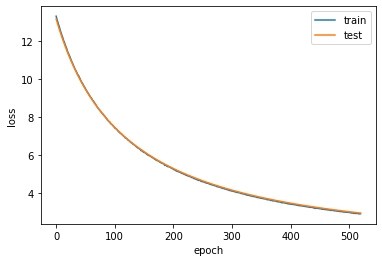

In [26]:
plt.plot(train_loss_data, label='train')
plt.plot(test_loss_data, label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [27]:
np_items = model.item_factors.weight.data.cpu().numpy()
np_users = model.user_factors.weight.data.cpu().numpy()
np_item_bias = model.item_biases.weight.data.cpu().numpy()
np_user_bias = model.user_biases.weight.data.cpu().numpy()

In [28]:
def cosine_similarity(a, b):
  return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [29]:
movie_id = movie_dict[2571] # the matrix
sim_dict = {}
for m, id in zip(np_items, movie_dict.keys()):
  sim_dict[id] = cosine_similarity(np_items[movie_id], m)

In [30]:
sim_pd = pd.DataFrame(sim_dict.items(), columns=['movieId', 'similarity'])
sim_pd = sim_pd.merge(movies_pd, on='movieId')

Топ 30 фильмов, наиболее похожих на фильм Матрица.
Недостаток подхода в поиске похожих фильмов по косинусной мере в том, что не учитывается bias

In [31]:
sim_pd.sort_values('similarity', ascending=False)[0:30][['title', 'genres', 'similarity']]

,title,genres,similarity
1938,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1.000000
81,Mary Reilly (1996),Drama|Horror|Thriller,0.208192
563,"Alphaville (Alphaville, une étrange aventure d...",Drama|Mystery|Romance|Sci-Fi|Thriller,0.202180
4366,Siam Sunset (1999),Comedy,0.194249
1152,Children of the Revolution (1996),Comedy,0.184851
637,Kazaam (1996),Children|Comedy|Fantasy,0.181895
2546,"Bear, The (Ours, L') (1988)",Adventure|Children|Drama,0.181517
5777,Howl's Moving Castle (Hauru no ugoku shiro) (2...,Adventure|Animation|Fantasy|Romance,0.179897
3326,"Great Outdoors, The (1988)",Comedy,0.179537
3633,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,0.179319


In [46]:
userId = 88
user_np = np_users[userId]
watched = np.transpose(data_pd[data_pd['userId'] == user_dict[42]][['movieId']].to_numpy())[0]
print(f"user {userId} watched {len(watched)} films")

user 88 watched 440 films


In [47]:
ratings_pred = np_items.dot(np_users[userId])

In [54]:
ratings_dict = {}
user_bias = np_user_bias[userId][0]
for pred, item_bias, id in zip(ratings_pred, np_item_bias, movie_dict.keys()):
  if not id in watched:
    ratings_dict[id] = pred + item_bias[0] + user_bias

In [55]:
ratings_pd = pd.DataFrame(ratings_dict.items(), columns=['movieId', 'rating'])
ratings_pd = ratings_pd.merge(movies_pd, on='movieId')

Топ 30 фильмов для пользователя

In [56]:
ratings_pd.sort_values('rating', ascending=False)[0:30][['title', 'genres', 'rating']]

,title,genres,rating
259,Forrest Gump (1994),Comedy|Drama|Romance|War,4.607818
218,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.561965
1662,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.489964
418,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.482793
83,Braveheart (1995),Action|Drama|War,4.317499
374,Schindler's List (1993),Drama|War,4.262557
189,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.252091
102,Apollo 13 (1995),Adventure|Drama|IMAX,4.210613
1931,Fight Club (1999),Action|Crime|Drama|Thriller,4.183253
416,Terminator 2: Judgment Day (1991),Action|Sci-Fi,4.178107
